In [1]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import os
import json
import numpy as np
import pandas as pd
import datetime as dt
from pathlib import Path
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts
from torch.cuda.amp import GradScaler, autocast

import optuna
from optuna.pruners import MedianPruner
from optuna.exceptions import TrialPruned
from optuna.importance import get_param_importances

from tqdm.auto import tqdm


In [2]:
ticker         = params.ticker
features_cols  = params.features_cols
label_col      = params.label_col
look_back      = params.look_back_tick

save_path = params.save_path
in_path   = save_path / f"{ticker}_ready.csv"
out_path  = save_path / f"{ticker}_final.csv"

# USE GPU if available, otherwise fallback to CPU
device = params.device
print("Using device:", device)

df_raw = pd.read_csv(in_path, index_col=0, parse_dates=True)
df  = models.feature_engineering(df_raw)
df.to_csv(out_path)
df

Using device: cuda


,open,high,low,close,volume,r_1,r_5,r_15,vol_15,volume_spike,vwap_dev,rsi_14,bid,ask,signal_smooth
2014-04-03 12:06:00,28.644845,28.644845,28.644845,28.644845,4580.0,-0.000180,-0.000180,-0.000180,0.000046,0.568641,-0.000178,0.000000,28.636251,28.653438,0.348124
2014-04-03 12:07:00,28.639690,28.639690,28.639690,28.639690,4540.0,-0.000180,-0.000360,-0.000360,0.000063,0.570338,-0.000355,0.000000,28.631098,28.648282,0.350528
2014-04-03 12:08:00,28.634534,28.634534,28.634534,28.634534,4500.0,-0.000180,-0.000540,-0.000540,0.000075,0.574408,-0.000531,0.000000,28.625944,28.643125,0.352926
2014-04-03 12:09:00,28.629379,28.629379,28.629379,28.629379,4460.0,-0.000180,-0.000720,-0.000720,0.000082,0.581017,-0.000705,0.000000,28.620791,28.637968,0.355320
2014-04-03 12:10:00,28.624224,28.624224,28.624224,28.624224,4420.0,-0.000180,-0.000900,-0.000900,0.000088,0.590413,-0.000878,0.000000,28.615637,28.632811,0.357710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,173.375000,173.677100,173.215000,173.565000,621199.0,0.001124,-0.004226,-0.009661,0.001493,2.462713,1.257638,17.019768,173.512900,173.617100,0.002995
2025-06-18 20:57:00,173.565000,173.590000,173.240000,173.380000,624198.0,-0.001066,-0.005063,-0.010671,0.001487,2.154838,1.255215,11.648165,173.328000,173.432000,0.002906
2025-06-18 20:58:00,173.390000,173.410000,173.200000,173.310000,454542.0,-0.000404,-0.005811,-0.011816,0.001436,1.439161,1.254293,11.384870,173.258000,173.362000,0.005611
2025-06-18 20:59:00,173.315000,173.400000,173.230000,173.280000,1094746.0,-0.000173,-0.004434,-0.011932,0.001432,2.836382,1.253874,11.830567,173.228000,173.332000,0.006685


In [3]:
# ──────────────────────────────────────────────────────────────────────────────
# Build LSTM input tensors (disk-backed memmaps)
#    Returns five tensors on `device`:
#      X        : (N, look_back, F)
#      y        : (N,)
#      raw_close: (N,)
#      raw_bid  : (N,)
#      raw_ask  : (N,)
# ──────────────────────────────────────────────────────────────────────────────
X, y, raw_close, raw_bid, raw_ask = models.build_lstm_tensors(
    df             = df,
    look_back      = look_back,
    features_cols  = features_cols,
    label_col      = label_col,
    regular_start  = params.regular_start_pred
)

print("Shapes:")
print("  X         =", X.shape,    "(samples, look_back, features)")
print("  y         =", y.shape,    "(samples,)")
print("  raw_close =", raw_close.shape)
print("  raw_bid   =", raw_bid.shape)
print("  raw_ask   =", raw_ask.shape)

Shapes:
  X         = torch.Size([1348808, 180, 12]) (samples, look_back, features)
  y         = torch.Size([1348808]) (samples,)
  raw_close = torch.Size([1348808])
  raw_bid   = torch.Size([1348808])
  raw_ask   = torch.Size([1348808])


In [4]:
# ──────────────────────────────────────────────────────────────────────────────
#    (We use the helper `chronological_split` that returns)
#      (X_tr, y_tr),
#      (X_val, y_val),
#      (X_te, y_te, raw_close_te, raw_bid_te, raw_ask_te)
# ──────────────────────────────────────────────────────────────────────────────
(X_tr, y_tr), \
(X_val, y_val), \
(X_te, y_te, raw_close_te, raw_bid_te, raw_ask_te), \
samples_per_day, day_id_tr, day_id_val, day_id_te = models.chronological_split(
    X, y, raw_close, raw_bid, raw_ask, df,
    look_back       = look_back,
    regular_start   = params.regular_start_pred,
    train_prop      = params.train_prop,
    val_prop        = params.val_prop,
    train_batch     = params.hparams['TRAIN_BATCH']
)

print("Shapes:")
print("  X_tr        =", X_tr.shape)
print("  y_tr        =", y_tr.shape)
print("  raw_close_te=", raw_close_te.shape)
print("  raw_bid_te  =", raw_bid_te.shape)
print("  raw_ask_te  =", raw_ask_te.shape)


Shapes:
  X_tr        = torch.Size([881299, 180, 12])
  y_tr        = torch.Size([881299])
  raw_close_te= torch.Size([239319])
  raw_bid_te  = torch.Size([239319])
  raw_ask_te  = torch.Size([239319])


In [5]:
# -----------------------------------------------------------------------------
#  Build DataLoaders over calendar‐days
# -----------------------------------------------------------------------------
train_loader, val_loader, test_loader = models.split_to_day_datasets(
    # Training split arrays (from chronological_split)
    X_tr, y_tr, day_id_tr,
    # Validation split arrays
    X_val, y_val, day_id_val,
    # Test split arrays + raw prices for post‐tracking
    X_te, y_te, day_id_te, raw_close_te, raw_bid_te, raw_ask_te,
    # Original minute‐bar DataFrame for weekday mapping
    df=df,
    train_batch=params.hparams['TRAIN_BATCH'],
    train_workers=params.hparams['NUM_WORKERS']
)

baseline_val_rmse = models.naive_rmse(val_loader)
print(f"\nBaseline (zero‐forecast) RMSE on validation = {baseline_val_rmse:.6f}")

▶️ Entered split_to_day_datasets
1) building weekday arrays
   Weekdays counts → tr=881299, val=228190, te=239319
2) moving all splits to CPU
   CPU casts done
3) zero-bas­ing day_id for val & test
   val_day_id ∈ [0..413], total days=414
   te_day_id  ∈ [0..421], total days=422
4) instantiating DayWindowDatasets
   ds_tr days: 1984
   ds_val days: 414
   ds_te days: 422
5) building DataLoaders
   train_loader ready
   val_loader ready
   test_loader ready

Baseline (zero‐forecast) RMSE on validation = 0.516034


In [6]:
# ──────────────────────────────────────────────────────────────────────────────
# Optuna objective definition
# ──────────────────────────────────────────────────────────────────────────────
def objective_train(trial):

    hp = {
        # ── Architecture ────────────────────────────────────────
        "DROPOUT_SHORT"     : trial.suggest_categorical(
            "DROPOUT_SHORT", [0.20, 0.25, 0.30, 0.35, 0.40]
        ),
        "DROPOUT_LONG"      : trial.suggest_categorical(
            "DROPOUT_LONG", [0.30, 0.35, 0.40, 0.45, 0.50]
        ),
        "ATT_DROPOUT"       : trial.suggest_categorical(
            "ATT_DROPOUT", [0.10, 0.15, 0.20, 0.25, 0.30]
        ),

        # ── Optimizer & Scheduler ──────────────────────────────
        "INITIAL_LR"        : trial.suggest_float(
            "INITIAL_LR", 1e-3, 1e-2
        ),
        "ETA_MIN"           : trial.suggest_float(
            "ETA_MIN", 1e-5, 1e-4
        ),
        "WEIGHT_DECAY"      : trial.suggest_categorical(
            "WEIGHT_DECAY", [3e-5, 1e-4, 3e-4, 1e-3, 3e-3]
        ),
        "CLIPNORM"          : trial.suggest_categorical(
            "CLIPNORM",
            [0.50, 0.70, 0.90, 1.00]
        ),
        "LR_EPOCHS_WARMUP"  : trial.suggest_categorical(
            "LR_EPOCHS_WARMUP",
            [1, 3, 5]
        ),
    }

    print(f"\n▶ Trial {trial.number} starting with:\n{hp}\n")

    # Build model
    model = models.DualMemoryLSTM(
        n_feats       = len(features_cols),
        short_units   = params.hparams["SHORT_UNITS"],
        long_units    = params.hparams["LONG_UNITS"],
        dropout_short = hp["DROPOUT_SHORT"],
        dropout_long  = hp["DROPOUT_LONG"],
        att_drop      = hp["ATT_DROPOUT"],
    ).to(device)

    # Build optimizer + schedulers + scaler
    optimizer, plateau_sched, _ , scaler, clipnorm = \
        models.make_optimizer_and_scheduler(
            model            = model,
            initial_lr       = hp["INITIAL_LR"],
            weight_decay     = hp["WEIGHT_DECAY"],
            clipnorm         = hp["CLIPNORM"]
        )

    cosine_sched = CosineAnnealingWarmRestarts(
        optimizer, 
        T_0=params.hparams['T_0'], 
        T_mult=params.hparams['T_MULT'], 
        eta_min=hp['ETA_MIN']
    )

    # Run training & return best validation RMSE
    best_rmse = models.custom_stateful_training_loop(
        model               = model,
        optimizer           = optimizer,
        cosine_sched        = cosine_sched,
        plateau_sched       = plateau_sched,
        scaler              = scaler,
        train_loader        = train_loader,
        val_loader          = val_loader,
        max_epochs          = params.hparams["MAX_EPOCHS"],
        early_stop_patience = params.hparams["EARLY_STOP_PATIENCE"],
        baseline_val_rmse   = baseline_val_rmse,
        clipnorm            = clipnorm,
        device              = device,
    )

    del model
    del optimizer
    del plateau_sched
    del cosine_sched
    del scaler

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    return best_rmse



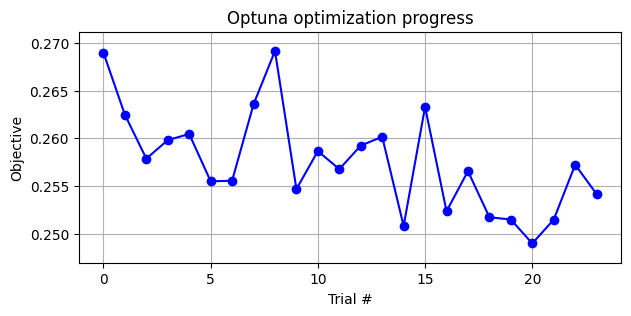

In [7]:
# ----------------------------------------------------------
# create ONE figure
# ----------------------------------------------------------
# build blank figure & line
fig, ax = plt.subplots(figsize=(7,3))
line, = ax.plot([], [], "bo-")
ax.set(xlabel="Trial #", ylabel="Objective",
       title="Optuna optimization progress")
ax.grid(True)

# display once and grab the handle
handle = display(fig, display_id=True)
plt.close(fig)

# ask plots.py for a callback bound to these objects
live_cb = plots.make_live_plot_callback(fig, ax, line, handle)

[I 2025-07-26 22:21:44,751] A new study created in RDB with name: no-name-ececa835-b0c4-4712-a526-e33fcbd43bb5



▶ Trial 0 starting with:
{'DROPOUT_SHORT': 0.4, 'DROPOUT_LONG': 0.45, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.3, 'INITIAL_LR': 0.0024402923794873176, 'ETA_MIN': 7.948625873847656e-05, 'WEIGHT_DECAY': 0.001, 'CLIPNORM': 0.7, 'LR_EPOCHS_WARMUP': 3}



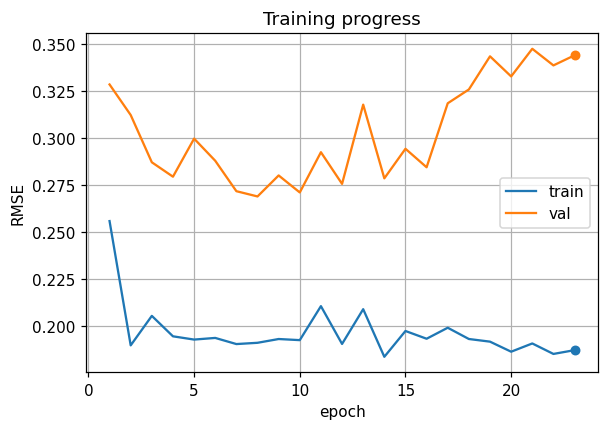

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.2559 • val=0.3287 • lr=2.44e-03


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.1897 • val=0.3124 • lr=2.43e-03


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2054 • val=0.2872 • lr=2.43e-03


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.1945 • val=0.2795 • lr=2.41e-03


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.1927 • val=0.2998 • lr=2.40e-03


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.1936 • val=0.2880 • lr=2.38e-03


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.1903 • val=0.2718 • lr=2.36e-03


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.1910 • val=0.2690 • lr=2.34e-03


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.1930 • val=0.2802 • lr=2.31e-03


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.1924 • val=0.2711 • lr=2.28e-03


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2105 • val=0.2926 • lr=2.25e-03


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.1904 • val=0.2757 • lr=2.22e-03


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2089 • val=0.3179 • lr=2.18e-03


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.1836 • val=0.2786 • lr=2.14e-03


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.1973 • val=0.2944 • lr=2.10e-03


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.1932 • val=0.2846 • lr=2.05e-03


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.1990 • val=0.3186 • lr=2.00e-03


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.1930 • val=0.3260 • lr=1.95e-03


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.1916 • val=0.3437 • lr=1.90e-03


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.1863 • val=0.3330 • lr=1.85e-03


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.1907 • val=0.3477 • lr=1.80e-03


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.1851 • val=0.3388 • lr=1.74e-03


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

[I 2025-07-26 22:44:37,350] Trial 0 finished with value: 0.26899579730210693 and parameters: {'DROPOUT_SHORT': 0.4, 'DROPOUT_LONG': 0.45, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.3, 'INITIAL_LR': 0.0024402923794873176, 'ETA_MIN': 7.948625873847656e-05, 'WEIGHT_DECAY': 0.001, 'CLIPNORM': 0.7, 'LR_EPOCHS_WARMUP': 3}. Best is trial 0 with value: 0.26899579730210693.


Epoch 023 • train=0.1871 • val=0.3442 • lr=1.68e-03
Early stopping at epoch 23

▶ Trial 1 starting with:
{'DROPOUT_SHORT': 0.3, 'DROPOUT_LONG': 0.45, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.3, 'INITIAL_LR': 0.008215744131942693, 'ETA_MIN': 1.822033221147135e-05, 'WEIGHT_DECAY': 0.001, 'CLIPNORM': 0.9, 'LR_EPOCHS_WARMUP': 3}



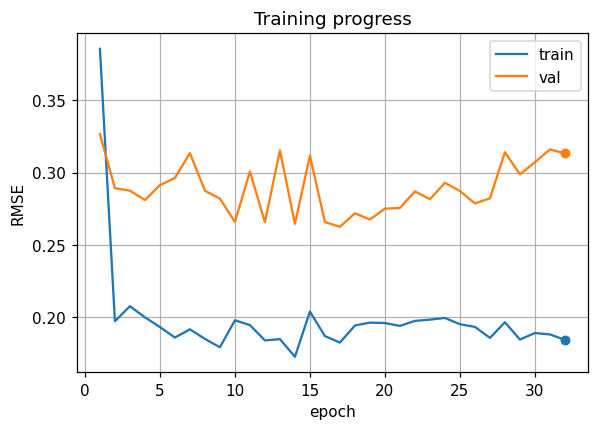

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.3857 • val=0.3267 • lr=8.21e-03


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.1971 • val=0.2892 • lr=8.19e-03


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2075 • val=0.2875 • lr=8.17e-03


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.1998 • val=0.2811 • lr=8.13e-03


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.1931 • val=0.2913 • lr=8.08e-03


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.1858 • val=0.2963 • lr=8.02e-03


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.1915 • val=0.3135 • lr=7.94e-03


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.1848 • val=0.2874 • lr=7.86e-03


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.1791 • val=0.2820 • lr=7.77e-03


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.1977 • val=0.2659 • lr=7.67e-03


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.1944 • val=0.3008 • lr=7.56e-03


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.1838 • val=0.2656 • lr=7.43e-03


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.1847 • val=0.3154 • lr=7.30e-03


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.1725 • val=0.2645 • lr=7.17e-03


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.2038 • val=0.3117 • lr=7.02e-03


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.1868 • val=0.2657 • lr=6.86e-03


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.1823 • val=0.2625 • lr=6.70e-03


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.1941 • val=0.2719 • lr=6.53e-03


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.1961 • val=0.2675 • lr=6.35e-03


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.1958 • val=0.2750 • lr=6.17e-03


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.1939 • val=0.2755 • lr=5.98e-03


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.1973 • val=0.2870 • lr=5.79e-03


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.1982 • val=0.2816 • lr=5.59e-03


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.1994 • val=0.2930 • lr=5.39e-03


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.1950 • val=0.2872 • lr=5.18e-03


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.1932 • val=0.2787 • lr=4.97e-03


Epoch 27:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 027 • train=0.1856 • val=0.2822 • lr=4.76e-03


Epoch 28:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 028 • train=0.1964 • val=0.3142 • lr=4.55e-03


Epoch 29:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 029 • train=0.1844 • val=0.2987 • lr=4.33e-03


Epoch 30:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 030 • train=0.1889 • val=0.3072 • lr=4.12e-03


Epoch 31:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 031 • train=0.1879 • val=0.3160 • lr=3.91e-03


Epoch 32:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 032 • train=0.1842 • val=0.3134 • lr=3.69e-03
Early stopping at epoch 32


[I 2025-07-26 23:16:21,768] Trial 1 finished with value: 0.26248108115586666 and parameters: {'DROPOUT_SHORT': 0.3, 'DROPOUT_LONG': 0.45, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.3, 'INITIAL_LR': 0.008215744131942693, 'ETA_MIN': 1.822033221147135e-05, 'WEIGHT_DECAY': 0.001, 'CLIPNORM': 0.9, 'LR_EPOCHS_WARMUP': 3}. Best is trial 1 with value: 0.26248108115586666.



▶ Trial 2 starting with:
{'DROPOUT_SHORT': 0.35, 'DROPOUT_LONG': 0.4, 'ATT_HEADS': 4, 'ATT_DROPOUT': 0.25, 'INITIAL_LR': 0.009999698471803539, 'ETA_MIN': 4.4679464781178236e-05, 'WEIGHT_DECAY': 0.0001, 'CLIPNORM': 1.0, 'LR_EPOCHS_WARMUP': 1}



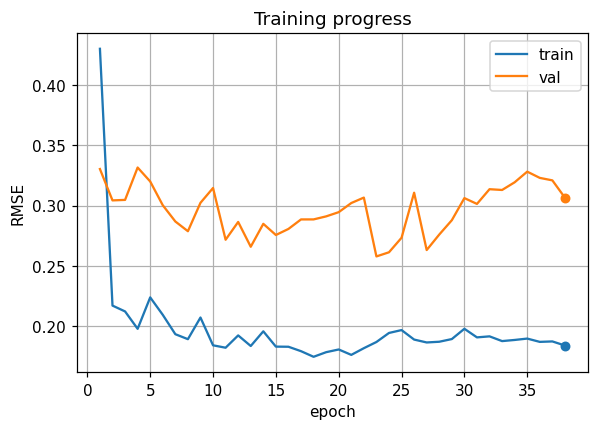

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.4302 • val=0.3304 • lr=9.99e-03


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2171 • val=0.3044 • lr=9.97e-03


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2122 • val=0.3048 • lr=9.94e-03


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.1978 • val=0.3317 • lr=9.89e-03


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2239 • val=0.3201 • lr=9.83e-03


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2094 • val=0.3004 • lr=9.76e-03


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.1933 • val=0.2869 • lr=9.67e-03


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.1892 • val=0.2788 • lr=9.57e-03


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2072 • val=0.3024 • lr=9.46e-03


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.1841 • val=0.3147 • lr=9.33e-03


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.1821 • val=0.2717 • lr=9.20e-03


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.1923 • val=0.2865 • lr=9.05e-03


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.1835 • val=0.2659 • lr=8.89e-03


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.1957 • val=0.2849 • lr=8.72e-03


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.1830 • val=0.2757 • lr=8.54e-03


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.1829 • val=0.2807 • lr=8.36e-03


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.1792 • val=0.2886 • lr=8.16e-03


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.1746 • val=0.2886 • lr=7.95e-03


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.1784 • val=0.2911 • lr=7.74e-03


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.1806 • val=0.2946 • lr=7.51e-03


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.1762 • val=0.3022 • lr=7.29e-03


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.1817 • val=0.3067 • lr=7.05e-03


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.1868 • val=0.2579 • lr=6.81e-03


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.1944 • val=0.2613 • lr=6.56e-03


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.1968 • val=0.2734 • lr=6.31e-03


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.1889 • val=0.3108 • lr=6.06e-03


Epoch 27:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 027 • train=0.1865 • val=0.2632 • lr=5.80e-03


Epoch 28:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 028 • train=0.1871 • val=0.2760 • lr=5.55e-03


Epoch 29:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 029 • train=0.1893 • val=0.2879 • lr=5.29e-03


Epoch 30:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 030 • train=0.1978 • val=0.3063 • lr=5.03e-03


Epoch 31:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 031 • train=0.1907 • val=0.3015 • lr=4.77e-03


Epoch 32:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 032 • train=0.1915 • val=0.3137 • lr=4.51e-03


Epoch 33:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 033 • train=0.1876 • val=0.3130 • lr=4.25e-03


Epoch 34:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 034 • train=0.1885 • val=0.3194 • lr=3.99e-03


Epoch 35:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 035 • train=0.1897 • val=0.3282 • lr=3.74e-03


Epoch 36:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 036 • train=0.1870 • val=0.3231 • lr=3.49e-03


Epoch 37:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 037 • train=0.1873 • val=0.3210 • lr=3.24e-03


Epoch 38:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 038 • train=0.1839 • val=0.3066 • lr=3.00e-03
Early stopping at epoch 38


[I 2025-07-26 23:43:40,084] Trial 2 finished with value: 0.25787461539713047 and parameters: {'DROPOUT_SHORT': 0.35, 'DROPOUT_LONG': 0.4, 'ATT_HEADS': 4, 'ATT_DROPOUT': 0.25, 'INITIAL_LR': 0.009999698471803539, 'ETA_MIN': 4.4679464781178236e-05, 'WEIGHT_DECAY': 0.0001, 'CLIPNORM': 1.0, 'LR_EPOCHS_WARMUP': 1}. Best is trial 2 with value: 0.25787461539713047.



▶ Trial 3 starting with:
{'DROPOUT_SHORT': 0.3, 'DROPOUT_LONG': 0.3, 'ATT_HEADS': 4, 'ATT_DROPOUT': 0.3, 'INITIAL_LR': 0.006066649387430545, 'ETA_MIN': 4.267198961068455e-05, 'WEIGHT_DECAY': 3e-05, 'CLIPNORM': 0.9, 'LR_EPOCHS_WARMUP': 1}



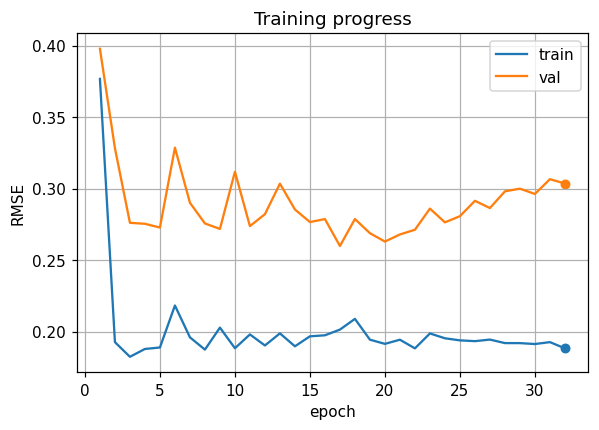

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.3767 • val=0.3978 • lr=6.06e-03


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.1926 • val=0.3282 • lr=6.05e-03


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.1823 • val=0.2760 • lr=6.03e-03


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.1878 • val=0.2753 • lr=6.00e-03


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.1888 • val=0.2727 • lr=5.96e-03


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2182 • val=0.3286 • lr=5.92e-03


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.1959 • val=0.2901 • lr=5.87e-03


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.1873 • val=0.2756 • lr=5.81e-03


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2027 • val=0.2717 • lr=5.74e-03


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.1883 • val=0.3118 • lr=5.66e-03


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.1979 • val=0.2737 • lr=5.58e-03


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.1902 • val=0.2821 • lr=5.49e-03


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.1987 • val=0.3034 • lr=5.40e-03


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.1897 • val=0.2854 • lr=5.29e-03


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.1966 • val=0.2766 • lr=5.19e-03


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.1973 • val=0.2787 • lr=5.07e-03


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.2013 • val=0.2598 • lr=4.95e-03


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.2088 • val=0.2787 • lr=4.83e-03


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.1943 • val=0.2688 • lr=4.70e-03


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.1913 • val=0.2629 • lr=4.56e-03


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.1943 • val=0.2679 • lr=4.42e-03


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.1882 • val=0.2712 • lr=4.28e-03


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.1986 • val=0.2860 • lr=4.14e-03


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.1953 • val=0.2764 • lr=3.99e-03


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.1938 • val=0.2807 • lr=3.84e-03


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.1933 • val=0.2914 • lr=3.68e-03


Epoch 27:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 027 • train=0.1943 • val=0.2864 • lr=3.53e-03


Epoch 28:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 028 • train=0.1919 • val=0.2980 • lr=3.37e-03


Epoch 29:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 029 • train=0.1919 • val=0.2999 • lr=3.21e-03


Epoch 30:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 030 • train=0.1912 • val=0.2962 • lr=3.06e-03


Epoch 31:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 031 • train=0.1926 • val=0.3066 • lr=2.90e-03


Epoch 32:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 032 • train=0.1882 • val=0.3035 • lr=2.74e-03
Early stopping at epoch 32


[I 2025-07-27 00:06:45,535] Trial 3 finished with value: 0.25981775370567545 and parameters: {'DROPOUT_SHORT': 0.3, 'DROPOUT_LONG': 0.3, 'ATT_HEADS': 4, 'ATT_DROPOUT': 0.3, 'INITIAL_LR': 0.006066649387430545, 'ETA_MIN': 4.267198961068455e-05, 'WEIGHT_DECAY': 3e-05, 'CLIPNORM': 0.9, 'LR_EPOCHS_WARMUP': 1}. Best is trial 2 with value: 0.25787461539713047.



▶ Trial 4 starting with:
{'DROPOUT_SHORT': 0.4, 'DROPOUT_LONG': 0.3, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.25, 'INITIAL_LR': 0.00240533275404029, 'ETA_MIN': 2.2240879276171564e-05, 'WEIGHT_DECAY': 0.0003, 'CLIPNORM': 1.0, 'LR_EPOCHS_WARMUP': 5}



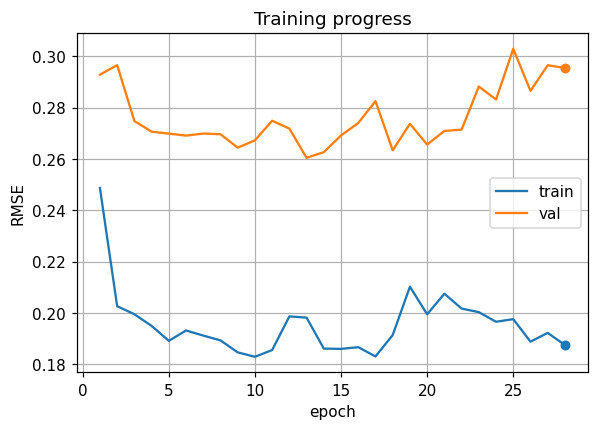

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.2487 • val=0.2928 • lr=2.40e-03


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2026 • val=0.2966 • lr=2.40e-03


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.1995 • val=0.2748 • lr=2.39e-03


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.1949 • val=0.2706 • lr=2.38e-03


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.1891 • val=0.2699 • lr=2.36e-03


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.1932 • val=0.2691 • lr=2.35e-03


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.1912 • val=0.2699 • lr=2.33e-03


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.1893 • val=0.2697 • lr=2.30e-03


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.1846 • val=0.2644 • lr=2.28e-03


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.1829 • val=0.2673 • lr=2.25e-03


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.1855 • val=0.2749 • lr=2.21e-03


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.1987 • val=0.2718 • lr=2.18e-03


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.1982 • val=0.2605 • lr=2.14e-03


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.1861 • val=0.2627 • lr=2.10e-03


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.1860 • val=0.2692 • lr=2.06e-03


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.1866 • val=0.2740 • lr=2.01e-03


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.1830 • val=0.2826 • lr=1.96e-03


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.1914 • val=0.2634 • lr=1.91e-03


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.2102 • val=0.2737 • lr=1.86e-03


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.1995 • val=0.2656 • lr=1.81e-03


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.2075 • val=0.2709 • lr=1.76e-03


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.2017 • val=0.2714 • lr=1.70e-03


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.2003 • val=0.2882 • lr=1.64e-03


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.1966 • val=0.2832 • lr=1.58e-03


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.1976 • val=0.3029 • lr=1.52e-03


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.1888 • val=0.2866 • lr=1.46e-03


Epoch 27:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 027 • train=0.1922 • val=0.2965 • lr=1.40e-03


Epoch 28:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 028 • train=0.1875 • val=0.2955 • lr=1.34e-03
Early stopping at epoch 28


[I 2025-07-27 00:34:16,265] Trial 4 finished with value: 0.2604641057598489 and parameters: {'DROPOUT_SHORT': 0.4, 'DROPOUT_LONG': 0.3, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.25, 'INITIAL_LR': 0.00240533275404029, 'ETA_MIN': 2.2240879276171564e-05, 'WEIGHT_DECAY': 0.0003, 'CLIPNORM': 1.0, 'LR_EPOCHS_WARMUP': 5}. Best is trial 2 with value: 0.25787461539713047.



▶ Trial 5 starting with:
{'DROPOUT_SHORT': 0.25, 'DROPOUT_LONG': 0.35, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.3, 'INITIAL_LR': 0.0039052425872999506, 'ETA_MIN': 4.929920398974706e-05, 'WEIGHT_DECAY': 0.001, 'CLIPNORM': 0.5, 'LR_EPOCHS_WARMUP': 3}



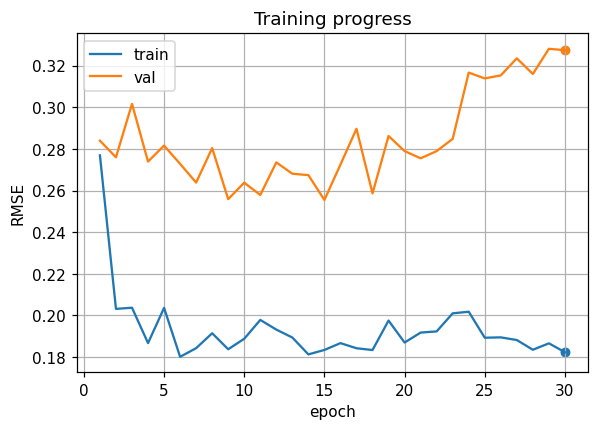

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.2769 • val=0.2840 • lr=3.90e-03


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2032 • val=0.2760 • lr=3.89e-03


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2037 • val=0.3016 • lr=3.88e-03


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.1867 • val=0.2739 • lr=3.86e-03


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2036 • val=0.2816 • lr=3.84e-03


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.1802 • val=0.2728 • lr=3.81e-03


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.1843 • val=0.2638 • lr=3.78e-03


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.1915 • val=0.2804 • lr=3.74e-03


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.1838 • val=0.2559 • lr=3.70e-03


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.1888 • val=0.2638 • lr=3.65e-03


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.1979 • val=0.2579 • lr=3.60e-03


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.1932 • val=0.2735 • lr=3.54e-03


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.1894 • val=0.2681 • lr=3.48e-03


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.1813 • val=0.2674 • lr=3.41e-03


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.1834 • val=0.2555 • lr=3.34e-03


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.1867 • val=0.2725 • lr=3.27e-03


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.1843 • val=0.2897 • lr=3.19e-03


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.1834 • val=0.2586 • lr=3.11e-03


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.1976 • val=0.2862 • lr=3.03e-03


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.1870 • val=0.2790 • lr=2.94e-03


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.1918 • val=0.2755 • lr=2.85e-03


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.1924 • val=0.2790 • lr=2.76e-03


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.2010 • val=0.2848 • lr=2.67e-03


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.2018 • val=0.3167 • lr=2.57e-03


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.1893 • val=0.3139 • lr=2.48e-03


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.1895 • val=0.3153 • lr=2.38e-03


Epoch 27:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 027 • train=0.1882 • val=0.3235 • lr=2.28e-03


Epoch 28:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 028 • train=0.1835 • val=0.3160 • lr=2.18e-03


Epoch 29:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 029 • train=0.1866 • val=0.3281 • lr=2.08e-03


Epoch 30:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 030 • train=0.1824 • val=0.3274 • lr=1.98e-03
Early stopping at epoch 30


[I 2025-07-27 01:03:41,859] Trial 5 finished with value: 0.2555004970475779 and parameters: {'DROPOUT_SHORT': 0.25, 'DROPOUT_LONG': 0.35, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.3, 'INITIAL_LR': 0.0039052425872999506, 'ETA_MIN': 4.929920398974706e-05, 'WEIGHT_DECAY': 0.001, 'CLIPNORM': 0.5, 'LR_EPOCHS_WARMUP': 3}. Best is trial 5 with value: 0.2555004970475779.



▶ Trial 6 starting with:
{'DROPOUT_SHORT': 0.35, 'DROPOUT_LONG': 0.5, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.25, 'INITIAL_LR': 0.002789113491114985, 'ETA_MIN': 4.64525543277027e-05, 'WEIGHT_DECAY': 0.0003, 'CLIPNORM': 0.9, 'LR_EPOCHS_WARMUP': 5}



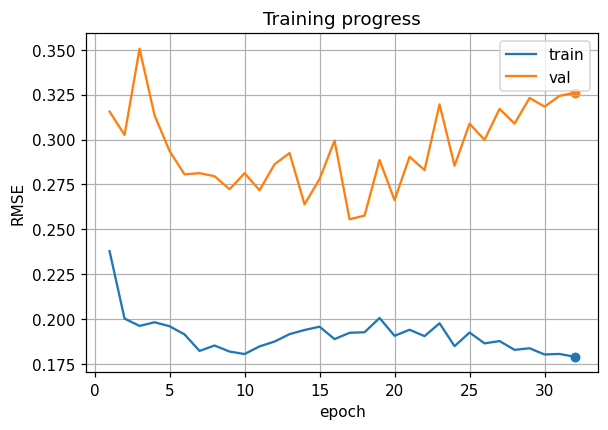

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.2378 • val=0.3156 • lr=2.79e-03


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2002 • val=0.3025 • lr=2.78e-03


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.1961 • val=0.3506 • lr=2.77e-03


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.1982 • val=0.3135 • lr=2.76e-03


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.1959 • val=0.2936 • lr=2.74e-03


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.1914 • val=0.2806 • lr=2.72e-03


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.1822 • val=0.2812 • lr=2.70e-03


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.1852 • val=0.2795 • lr=2.67e-03


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.1818 • val=0.2723 • lr=2.64e-03


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.1804 • val=0.2812 • lr=2.61e-03


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.1847 • val=0.2717 • lr=2.57e-03


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.1874 • val=0.2862 • lr=2.53e-03


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.1915 • val=0.2924 • lr=2.48e-03


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.1939 • val=0.2639 • lr=2.44e-03


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.1957 • val=0.2779 • lr=2.39e-03


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.1888 • val=0.2994 • lr=2.34e-03


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.1923 • val=0.2556 • lr=2.28e-03


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.1926 • val=0.2576 • lr=2.22e-03


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.2005 • val=0.2885 • lr=2.17e-03


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.1906 • val=0.2662 • lr=2.10e-03


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.1940 • val=0.2904 • lr=2.04e-03


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.1904 • val=0.2830 • lr=1.98e-03


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.1976 • val=0.3196 • lr=1.91e-03


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.1848 • val=0.2854 • lr=1.84e-03


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.1924 • val=0.3088 • lr=1.77e-03


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.1864 • val=0.2998 • lr=1.70e-03


Epoch 27:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 027 • train=0.1877 • val=0.3171 • lr=1.63e-03


Epoch 28:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 028 • train=0.1828 • val=0.3088 • lr=1.56e-03


Epoch 29:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 029 • train=0.1837 • val=0.3232 • lr=1.49e-03


Epoch 30:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 030 • train=0.1802 • val=0.3183 • lr=1.42e-03


Epoch 31:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 031 • train=0.1805 • val=0.3243 • lr=1.35e-03


Epoch 32:   0%|          | 0/62 [00:00<?, ?bundle/s]

[I 2025-07-27 01:35:11,119] Trial 6 finished with value: 0.25555408289521236 and parameters: {'DROPOUT_SHORT': 0.35, 'DROPOUT_LONG': 0.5, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.25, 'INITIAL_LR': 0.002789113491114985, 'ETA_MIN': 4.64525543277027e-05, 'WEIGHT_DECAY': 0.0003, 'CLIPNORM': 0.9, 'LR_EPOCHS_WARMUP': 5}. Best is trial 5 with value: 0.2555004970475779.


Epoch 032 • train=0.1789 • val=0.3261 • lr=1.28e-03
Early stopping at epoch 32

▶ Trial 7 starting with:
{'DROPOUT_SHORT': 0.4, 'DROPOUT_LONG': 0.45, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.15, 'INITIAL_LR': 0.004545359328987144, 'ETA_MIN': 5.0927857753587554e-05, 'WEIGHT_DECAY': 0.003, 'CLIPNORM': 0.9, 'LR_EPOCHS_WARMUP': 3}



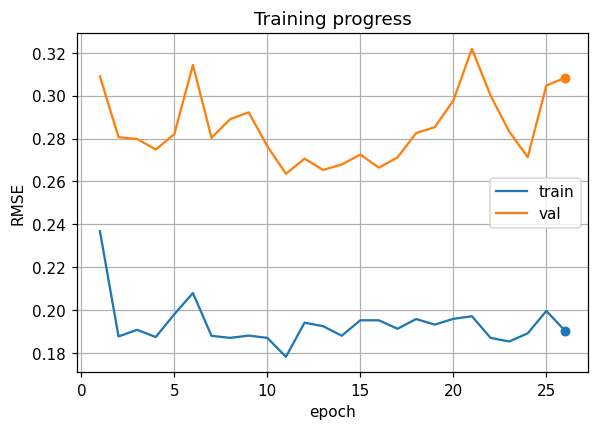

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.2367 • val=0.3090 • lr=4.54e-03


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.1877 • val=0.2807 • lr=4.53e-03


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.1908 • val=0.2798 • lr=4.52e-03


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.1874 • val=0.2749 • lr=4.50e-03


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.1980 • val=0.2821 • lr=4.47e-03


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2079 • val=0.3143 • lr=4.44e-03


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.1879 • val=0.2804 • lr=4.40e-03


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.1870 • val=0.2890 • lr=4.35e-03


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.1881 • val=0.2922 • lr=4.30e-03


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.1870 • val=0.2764 • lr=4.25e-03


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.1782 • val=0.2636 • lr=4.18e-03


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.1941 • val=0.2706 • lr=4.12e-03


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.1925 • val=0.2654 • lr=4.05e-03


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.1880 • val=0.2679 • lr=3.97e-03


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.1952 • val=0.2725 • lr=3.89e-03


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.1952 • val=0.2664 • lr=3.80e-03


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.1913 • val=0.2712 • lr=3.71e-03


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.1958 • val=0.2825 • lr=3.62e-03


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.1932 • val=0.2853 • lr=3.52e-03


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.1959 • val=0.2977 • lr=3.42e-03


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.1971 • val=0.3219 • lr=3.32e-03


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.1870 • val=0.3000 • lr=3.21e-03


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.1853 • val=0.2833 • lr=3.11e-03


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.1891 • val=0.2713 • lr=2.99e-03


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.1996 • val=0.3047 • lr=2.88e-03


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.1904 • val=0.3083 • lr=2.77e-03
Early stopping at epoch 26


[I 2025-07-27 02:00:49,059] Trial 7 finished with value: 0.2635763866858972 and parameters: {'DROPOUT_SHORT': 0.4, 'DROPOUT_LONG': 0.45, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.15, 'INITIAL_LR': 0.004545359328987144, 'ETA_MIN': 5.0927857753587554e-05, 'WEIGHT_DECAY': 0.003, 'CLIPNORM': 0.9, 'LR_EPOCHS_WARMUP': 3}. Best is trial 5 with value: 0.2555004970475779.



▶ Trial 8 starting with:
{'DROPOUT_SHORT': 0.25, 'DROPOUT_LONG': 0.4, 'ATT_HEADS': 4, 'ATT_DROPOUT': 0.2, 'INITIAL_LR': 0.002553625809683437, 'ETA_MIN': 9.398153198678467e-05, 'WEIGHT_DECAY': 0.0001, 'CLIPNORM': 1.0, 'LR_EPOCHS_WARMUP': 3}



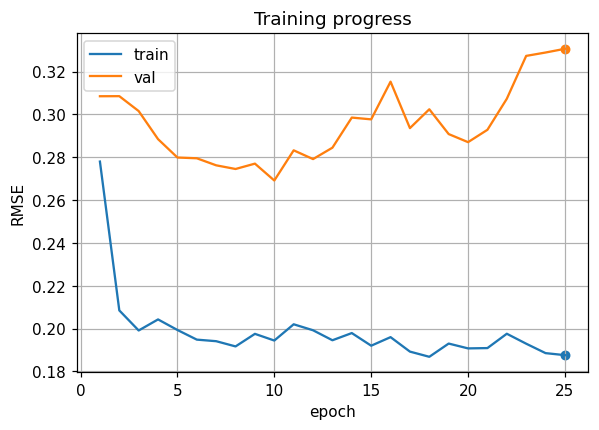

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.2780 • val=0.3085 • lr=2.55e-03


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2085 • val=0.3086 • lr=2.55e-03


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.1991 • val=0.3016 • lr=2.54e-03


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2043 • val=0.2885 • lr=2.53e-03


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.1994 • val=0.2799 • lr=2.51e-03


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.1949 • val=0.2795 • lr=2.49e-03


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.1941 • val=0.2763 • lr=2.47e-03


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.1917 • val=0.2745 • lr=2.45e-03


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.1976 • val=0.2770 • lr=2.42e-03


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.1945 • val=0.2692 • lr=2.39e-03


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2020 • val=0.2833 • lr=2.36e-03


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.1992 • val=0.2792 • lr=2.32e-03


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.1946 • val=0.2845 • lr=2.28e-03


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.1979 • val=0.2986 • lr=2.24e-03


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.1920 • val=0.2977 • lr=2.19e-03


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.1960 • val=0.3153 • lr=2.15e-03


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.1893 • val=0.2936 • lr=2.10e-03


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.1869 • val=0.3024 • lr=2.05e-03


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.1930 • val=0.2909 • lr=1.99e-03


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.1908 • val=0.2871 • lr=1.94e-03


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.1909 • val=0.2928 • lr=1.88e-03


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.1976 • val=0.3073 • lr=1.82e-03


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.1930 • val=0.3274 • lr=1.77e-03


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.1886 • val=0.3289 • lr=1.70e-03


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

[I 2025-07-27 02:19:14,222] Trial 8 finished with value: 0.2691706048307544 and parameters: {'DROPOUT_SHORT': 0.25, 'DROPOUT_LONG': 0.4, 'ATT_HEADS': 4, 'ATT_DROPOUT': 0.2, 'INITIAL_LR': 0.002553625809683437, 'ETA_MIN': 9.398153198678467e-05, 'WEIGHT_DECAY': 0.0001, 'CLIPNORM': 1.0, 'LR_EPOCHS_WARMUP': 3}. Best is trial 5 with value: 0.2555004970475779.


Epoch 025 • train=0.1876 • val=0.3307 • lr=1.64e-03
Early stopping at epoch 25

▶ Trial 9 starting with:
{'DROPOUT_SHORT': 0.35, 'DROPOUT_LONG': 0.5, 'ATT_HEADS': 4, 'ATT_DROPOUT': 0.2, 'INITIAL_LR': 0.006422608099398236, 'ETA_MIN': 7.142030894854927e-05, 'WEIGHT_DECAY': 0.001, 'CLIPNORM': 0.5, 'LR_EPOCHS_WARMUP': 3}



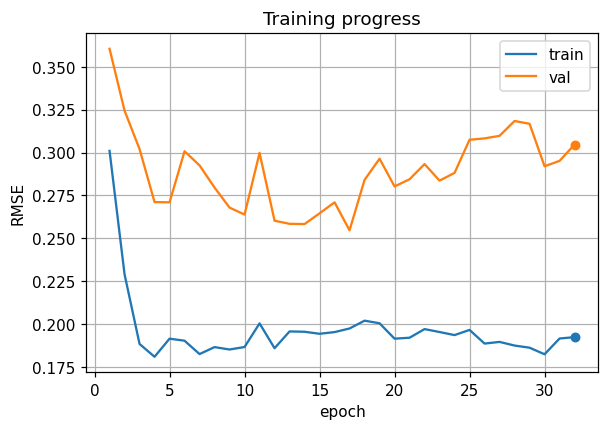

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.3010 • val=0.3605 • lr=6.42e-03


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2290 • val=0.3245 • lr=6.41e-03


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.1884 • val=0.3020 • lr=6.38e-03


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.1809 • val=0.2711 • lr=6.35e-03


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.1915 • val=0.2710 • lr=6.32e-03


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.1903 • val=0.3008 • lr=6.27e-03


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.1825 • val=0.2925 • lr=6.21e-03


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.1866 • val=0.2796 • lr=6.15e-03


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.1852 • val=0.2679 • lr=6.08e-03


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.1866 • val=0.2639 • lr=6.00e-03


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2004 • val=0.2998 • lr=5.91e-03


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.1859 • val=0.2603 • lr=5.82e-03


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.1957 • val=0.2585 • lr=5.72e-03


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.1955 • val=0.2583 • lr=5.61e-03


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.1943 • val=0.2646 • lr=5.49e-03


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.1953 • val=0.2710 • lr=5.37e-03


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.1974 • val=0.2547 • lr=5.25e-03


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.2020 • val=0.2841 • lr=5.12e-03


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.2005 • val=0.2964 • lr=4.98e-03


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.1915 • val=0.2803 • lr=4.84e-03


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.1920 • val=0.2844 • lr=4.69e-03


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.1971 • val=0.2933 • lr=4.54e-03


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.1954 • val=0.2836 • lr=4.39e-03


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.1936 • val=0.2882 • lr=4.23e-03


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.1966 • val=0.3075 • lr=4.07e-03


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.1886 • val=0.3083 • lr=3.91e-03


Epoch 27:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 027 • train=0.1896 • val=0.3098 • lr=3.75e-03


Epoch 28:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 028 • train=0.1875 • val=0.3184 • lr=3.58e-03


Epoch 29:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 029 • train=0.1862 • val=0.3168 • lr=3.42e-03


Epoch 30:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 030 • train=0.1824 • val=0.2920 • lr=3.25e-03


Epoch 31:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 031 • train=0.1916 • val=0.2952 • lr=3.08e-03


Epoch 32:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 032 • train=0.1924 • val=0.3047 • lr=2.92e-03
Early stopping at epoch 32


[I 2025-07-27 02:42:52,477] Trial 9 finished with value: 0.2546744626560615 and parameters: {'DROPOUT_SHORT': 0.35, 'DROPOUT_LONG': 0.5, 'ATT_HEADS': 4, 'ATT_DROPOUT': 0.2, 'INITIAL_LR': 0.006422608099398236, 'ETA_MIN': 7.142030894854927e-05, 'WEIGHT_DECAY': 0.001, 'CLIPNORM': 0.5, 'LR_EPOCHS_WARMUP': 3}. Best is trial 9 with value: 0.2546744626560615.



▶ Trial 10 starting with:
{'DROPOUT_SHORT': 0.2, 'DROPOUT_LONG': 0.5, 'ATT_HEADS': 4, 'ATT_DROPOUT': 0.2, 'INITIAL_LR': 0.006197024245852246, 'ETA_MIN': 7.186211555685014e-05, 'WEIGHT_DECAY': 3e-05, 'CLIPNORM': 0.5, 'LR_EPOCHS_WARMUP': 1}



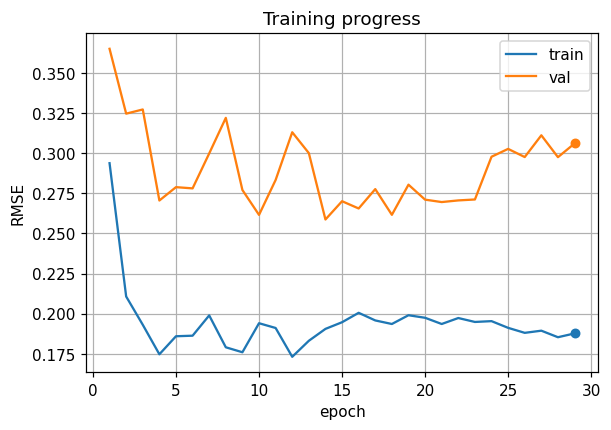

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.2938 • val=0.3650 • lr=6.19e-03


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2107 • val=0.3246 • lr=6.18e-03


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.1931 • val=0.3272 • lr=6.16e-03


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.1747 • val=0.2705 • lr=6.13e-03


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.1859 • val=0.2788 • lr=6.09e-03


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.1863 • val=0.2781 • lr=6.05e-03


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.1989 • val=0.2998 • lr=5.99e-03


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.1790 • val=0.3220 • lr=5.93e-03


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.1759 • val=0.2770 • lr=5.86e-03


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.1940 • val=0.2615 • lr=5.79e-03


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.1911 • val=0.2833 • lr=5.70e-03


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.1731 • val=0.3130 • lr=5.61e-03


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.1831 • val=0.3000 • lr=5.52e-03


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.1905 • val=0.2587 • lr=5.41e-03


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.1946 • val=0.2701 • lr=5.30e-03


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.2005 • val=0.2655 • lr=5.19e-03


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.1958 • val=0.2776 • lr=5.06e-03


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.1935 • val=0.2616 • lr=4.94e-03


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.1990 • val=0.2804 • lr=4.80e-03


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.1974 • val=0.2710 • lr=4.67e-03


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.1935 • val=0.2695 • lr=4.53e-03


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.1973 • val=0.2706 • lr=4.38e-03


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.1948 • val=0.2711 • lr=4.23e-03


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.1953 • val=0.2978 • lr=4.08e-03


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.1911 • val=0.3027 • lr=3.93e-03


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.1880 • val=0.2976 • lr=3.77e-03


Epoch 27:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 027 • train=0.1894 • val=0.3111 • lr=3.62e-03


Epoch 28:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 028 • train=0.1853 • val=0.2975 • lr=3.46e-03


Epoch 29:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 029 • train=0.1877 • val=0.3060 • lr=3.30e-03
Early stopping at epoch 29


[I 2025-07-27 03:04:21,610] Trial 10 finished with value: 0.25866977781823264 and parameters: {'DROPOUT_SHORT': 0.2, 'DROPOUT_LONG': 0.5, 'ATT_HEADS': 4, 'ATT_DROPOUT': 0.2, 'INITIAL_LR': 0.006197024245852246, 'ETA_MIN': 7.186211555685014e-05, 'WEIGHT_DECAY': 3e-05, 'CLIPNORM': 0.5, 'LR_EPOCHS_WARMUP': 1}. Best is trial 9 with value: 0.2546744626560615.



▶ Trial 11 starting with:
{'DROPOUT_SHORT': 0.25, 'DROPOUT_LONG': 0.35, 'ATT_HEADS': 4, 'ATT_DROPOUT': 0.1, 'INITIAL_LR': 0.004525243264965069, 'ETA_MIN': 6.988879026354303e-05, 'WEIGHT_DECAY': 0.001, 'CLIPNORM': 0.5, 'LR_EPOCHS_WARMUP': 3}



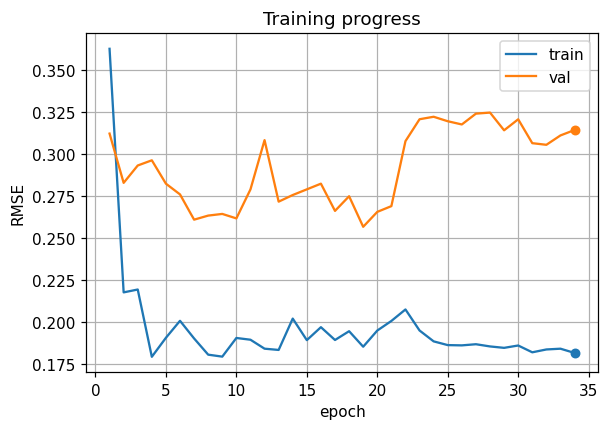

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.3627 • val=0.3122 • lr=4.52e-03


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2178 • val=0.2829 • lr=4.51e-03


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2195 • val=0.2932 • lr=4.50e-03


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.1794 • val=0.2963 • lr=4.48e-03


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.1907 • val=0.2824 • lr=4.45e-03


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2008 • val=0.2760 • lr=4.42e-03


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.1903 • val=0.2610 • lr=4.38e-03


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.1807 • val=0.2634 • lr=4.33e-03


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.1795 • val=0.2644 • lr=4.28e-03


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.1906 • val=0.2618 • lr=4.23e-03


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.1896 • val=0.2790 • lr=4.17e-03


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.1842 • val=0.3083 • lr=4.10e-03


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.1835 • val=0.2717 • lr=4.03e-03


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.2021 • val=0.2757 • lr=3.95e-03


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.1893 • val=0.2790 • lr=3.87e-03


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.1970 • val=0.2824 • lr=3.79e-03


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.1894 • val=0.2662 • lr=3.70e-03


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.1947 • val=0.2750 • lr=3.61e-03


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.1854 • val=0.2568 • lr=3.51e-03


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.1950 • val=0.2656 • lr=3.41e-03


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.2007 • val=0.2691 • lr=3.31e-03


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.2076 • val=0.3077 • lr=3.21e-03


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.1951 • val=0.3208 • lr=3.10e-03


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.1886 • val=0.3222 • lr=2.99e-03


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.1864 • val=0.3196 • lr=2.88e-03


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.1862 • val=0.3177 • lr=2.76e-03


Epoch 27:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 027 • train=0.1869 • val=0.3241 • lr=2.65e-03


Epoch 28:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 028 • train=0.1856 • val=0.3247 • lr=2.53e-03


Epoch 29:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 029 • train=0.1847 • val=0.3142 • lr=2.42e-03


Epoch 30:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 030 • train=0.1861 • val=0.3207 • lr=2.30e-03


Epoch 31:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 031 • train=0.1821 • val=0.3065 • lr=2.18e-03


Epoch 32:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 032 • train=0.1838 • val=0.3056 • lr=2.07e-03


Epoch 33:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 033 • train=0.1842 • val=0.3111 • lr=1.95e-03


Epoch 34:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 034 • train=0.1817 • val=0.3144 • lr=1.84e-03
Early stopping at epoch 34


[I 2025-07-27 03:29:36,805] Trial 11 finished with value: 0.2567725063705291 and parameters: {'DROPOUT_SHORT': 0.25, 'DROPOUT_LONG': 0.35, 'ATT_HEADS': 4, 'ATT_DROPOUT': 0.1, 'INITIAL_LR': 0.004525243264965069, 'ETA_MIN': 6.988879026354303e-05, 'WEIGHT_DECAY': 0.001, 'CLIPNORM': 0.5, 'LR_EPOCHS_WARMUP': 3}. Best is trial 9 with value: 0.2546744626560615.



▶ Trial 12 starting with:
{'DROPOUT_SHORT': 0.35, 'DROPOUT_LONG': 0.35, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.2, 'INITIAL_LR': 0.007737525243553171, 'ETA_MIN': 6.279819430611233e-05, 'WEIGHT_DECAY': 0.001, 'CLIPNORM': 0.5, 'LR_EPOCHS_WARMUP': 3}



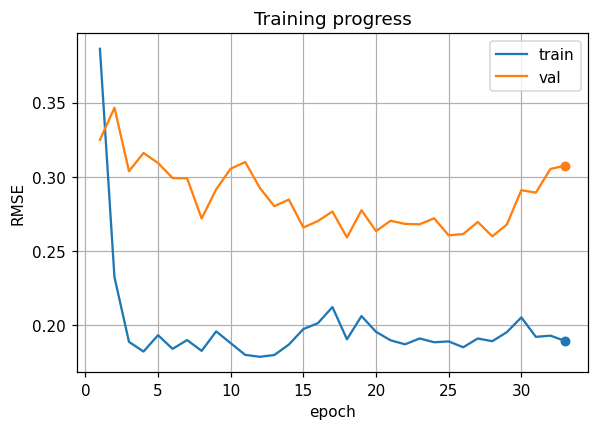

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.3863 • val=0.3249 • lr=7.73e-03


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2325 • val=0.3466 • lr=7.72e-03


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.1889 • val=0.3039 • lr=7.69e-03


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.1824 • val=0.3162 • lr=7.65e-03


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.1934 • val=0.3094 • lr=7.61e-03


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.1842 • val=0.2993 • lr=7.55e-03


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.1901 • val=0.2991 • lr=7.48e-03


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.1828 • val=0.2720 • lr=7.41e-03


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.1960 • val=0.2916 • lr=7.32e-03


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.1880 • val=0.3056 • lr=7.23e-03


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.1801 • val=0.3100 • lr=7.12e-03


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.1789 • val=0.2927 • lr=7.01e-03


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.1800 • val=0.2803 • lr=6.88e-03


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.1871 • val=0.2848 • lr=6.75e-03


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.1975 • val=0.2659 • lr=6.62e-03


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.2015 • val=0.2703 • lr=6.47e-03


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.2124 • val=0.2767 • lr=6.32e-03


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.1907 • val=0.2592 • lr=6.16e-03


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.2063 • val=0.2776 • lr=5.99e-03


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.1957 • val=0.2635 • lr=5.82e-03


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.1900 • val=0.2705 • lr=5.65e-03


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.1873 • val=0.2684 • lr=5.46e-03


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.1912 • val=0.2681 • lr=5.28e-03


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.1887 • val=0.2721 • lr=5.09e-03


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.1892 • val=0.2607 • lr=4.90e-03


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.1853 • val=0.2615 • lr=4.70e-03


Epoch 27:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 027 • train=0.1912 • val=0.2697 • lr=4.50e-03


Epoch 28:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 028 • train=0.1894 • val=0.2600 • lr=4.30e-03


Epoch 29:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 029 • train=0.1954 • val=0.2679 • lr=4.10e-03


Epoch 30:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 030 • train=0.2054 • val=0.2911 • lr=3.90e-03


Epoch 31:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 031 • train=0.1923 • val=0.2894 • lr=3.70e-03


Epoch 32:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 032 • train=0.1931 • val=0.3054 • lr=3.50e-03


Epoch 33:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 033 • train=0.1896 • val=0.3076 • lr=3.30e-03
Early stopping at epoch 33


[I 2025-07-27 04:02:34,085] Trial 12 finished with value: 0.2592416983674661 and parameters: {'DROPOUT_SHORT': 0.35, 'DROPOUT_LONG': 0.35, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.2, 'INITIAL_LR': 0.007737525243553171, 'ETA_MIN': 6.279819430611233e-05, 'WEIGHT_DECAY': 0.001, 'CLIPNORM': 0.5, 'LR_EPOCHS_WARMUP': 3}. Best is trial 9 with value: 0.2546744626560615.



▶ Trial 13 starting with:
{'DROPOUT_SHORT': 0.25, 'DROPOUT_LONG': 0.5, 'ATT_HEADS': 4, 'ATT_DROPOUT': 0.1, 'INITIAL_LR': 0.004133071934979577, 'ETA_MIN': 8.978425519774021e-05, 'WEIGHT_DECAY': 0.001, 'CLIPNORM': 0.5, 'LR_EPOCHS_WARMUP': 3}



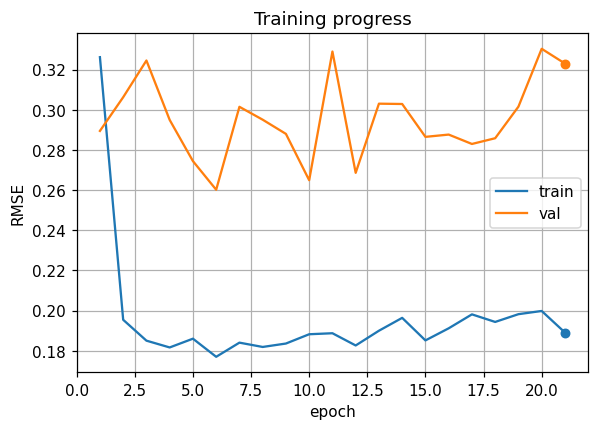

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.3262 • val=0.2895 • lr=4.13e-03


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.1954 • val=0.3062 • lr=4.12e-03


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.1850 • val=0.3245 • lr=4.11e-03


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.1817 • val=0.2949 • lr=4.09e-03


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.1860 • val=0.2744 • lr=4.06e-03


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.1770 • val=0.2602 • lr=4.03e-03


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.1840 • val=0.3015 • lr=4.00e-03


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.1819 • val=0.2950 • lr=3.96e-03


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.1836 • val=0.2880 • lr=3.91e-03


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.1882 • val=0.2649 • lr=3.86e-03


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.1887 • val=0.3290 • lr=3.81e-03


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.1826 • val=0.2686 • lr=3.75e-03


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.1900 • val=0.3030 • lr=3.68e-03


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.1964 • val=0.3029 • lr=3.61e-03


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.1852 • val=0.2865 • lr=3.54e-03


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.1912 • val=0.2876 • lr=3.47e-03


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.1981 • val=0.2830 • lr=3.39e-03


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.1944 • val=0.2858 • lr=3.30e-03


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.1982 • val=0.3015 • lr=3.21e-03


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.1998 • val=0.3303 • lr=3.12e-03


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.1891 • val=0.3230 • lr=3.03e-03
Early stopping at epoch 21


[I 2025-07-27 04:18:18,503] Trial 13 finished with value: 0.26017159932536327 and parameters: {'DROPOUT_SHORT': 0.25, 'DROPOUT_LONG': 0.5, 'ATT_HEADS': 4, 'ATT_DROPOUT': 0.1, 'INITIAL_LR': 0.004133071934979577, 'ETA_MIN': 8.978425519774021e-05, 'WEIGHT_DECAY': 0.001, 'CLIPNORM': 0.5, 'LR_EPOCHS_WARMUP': 3}. Best is trial 9 with value: 0.2546744626560615.



▶ Trial 14 starting with:
{'DROPOUT_SHORT': 0.2, 'DROPOUT_LONG': 0.35, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.15, 'INITIAL_LR': 0.007310364161499348, 'ETA_MIN': 3.142778568084042e-05, 'WEIGHT_DECAY': 0.003, 'CLIPNORM': 0.5, 'LR_EPOCHS_WARMUP': 3}



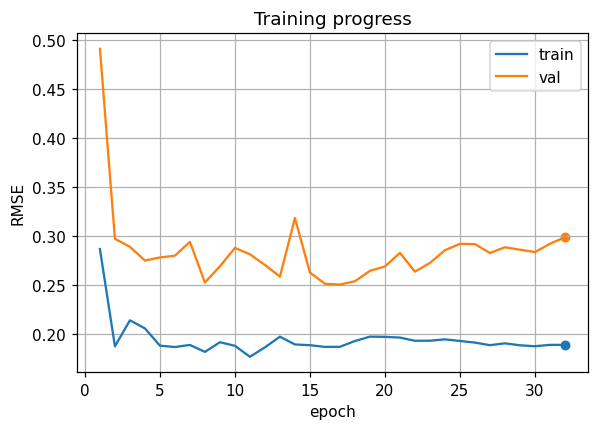

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.2870 • val=0.4910 • lr=7.31e-03


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.1879 • val=0.2975 • lr=7.29e-03


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2143 • val=0.2892 • lr=7.27e-03


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2061 • val=0.2753 • lr=7.23e-03


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.1886 • val=0.2784 • lr=7.19e-03


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.1872 • val=0.2803 • lr=7.13e-03


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.1893 • val=0.2943 • lr=7.07e-03


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.1822 • val=0.2529 • lr=7.00e-03


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.1921 • val=0.2695 • lr=6.92e-03


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.1884 • val=0.2881 • lr=6.82e-03


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.1772 • val=0.2817 • lr=6.72e-03


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.1869 • val=0.2708 • lr=6.62e-03


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.1977 • val=0.2590 • lr=6.50e-03


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.1898 • val=0.3186 • lr=6.38e-03


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.1890 • val=0.2631 • lr=6.25e-03


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.1873 • val=0.2516 • lr=6.11e-03


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.1874 • val=0.2508 • lr=5.96e-03
Saved new best model: GOOGL_0.2508.pth


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.1933 • val=0.2542 • lr=5.81e-03


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.1977 • val=0.2648 • lr=5.66e-03


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.1975 • val=0.2693 • lr=5.49e-03


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.1968 • val=0.2831 • lr=5.33e-03


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.1935 • val=0.2640 • lr=5.15e-03


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.1936 • val=0.2728 • lr=4.98e-03


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.1950 • val=0.2858 • lr=4.80e-03


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.1933 • val=0.2923 • lr=4.62e-03


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.1917 • val=0.2921 • lr=4.43e-03


Epoch 27:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 027 • train=0.1890 • val=0.2830 • lr=4.24e-03


Epoch 28:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 028 • train=0.1909 • val=0.2889 • lr=4.05e-03


Epoch 29:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 029 • train=0.1889 • val=0.2863 • lr=3.86e-03


Epoch 30:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 030 • train=0.1880 • val=0.2839 • lr=3.67e-03


Epoch 31:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 031 • train=0.1894 • val=0.2924 • lr=3.48e-03


Epoch 32:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 032 • train=0.1893 • val=0.2991 • lr=3.29e-03
Early stopping at epoch 32


[I 2025-07-27 04:50:28,694] Trial 14 finished with value: 0.25080742856736177 and parameters: {'DROPOUT_SHORT': 0.2, 'DROPOUT_LONG': 0.35, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.15, 'INITIAL_LR': 0.007310364161499348, 'ETA_MIN': 3.142778568084042e-05, 'WEIGHT_DECAY': 0.003, 'CLIPNORM': 0.5, 'LR_EPOCHS_WARMUP': 3}. Best is trial 14 with value: 0.25080742856736177.



▶ Trial 15 starting with:
{'DROPOUT_SHORT': 0.2, 'DROPOUT_LONG': 0.5, 'ATT_HEADS': 4, 'ATT_DROPOUT': 0.15, 'INITIAL_LR': 0.007114574000182431, 'ETA_MIN': 2.5109772565099194e-05, 'WEIGHT_DECAY': 0.003, 'CLIPNORM': 0.7, 'LR_EPOCHS_WARMUP': 5}



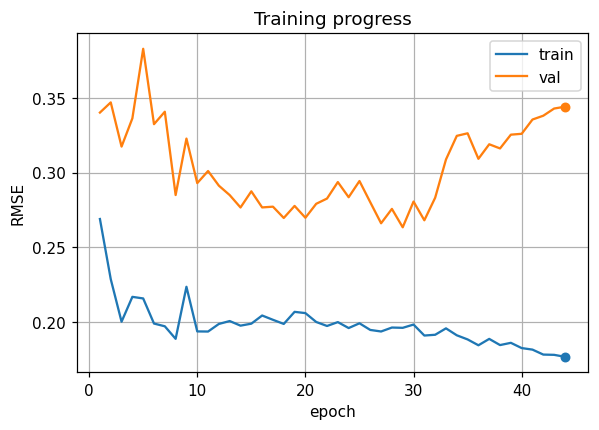

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.2689 • val=0.3401 • lr=7.11e-03


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2286 • val=0.3469 • lr=7.10e-03


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2001 • val=0.3174 • lr=7.07e-03


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2167 • val=0.3363 • lr=7.04e-03


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2157 • val=0.3828 • lr=6.99e-03


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.1989 • val=0.3324 • lr=6.94e-03


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.1970 • val=0.3407 • lr=6.88e-03


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.1886 • val=0.2849 • lr=6.81e-03


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2235 • val=0.3227 • lr=6.73e-03


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.1936 • val=0.2929 • lr=6.64e-03


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.1935 • val=0.3010 • lr=6.54e-03


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.1986 • val=0.2912 • lr=6.44e-03


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2005 • val=0.2849 • lr=6.33e-03


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.1975 • val=0.2766 • lr=6.21e-03


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.1988 • val=0.2874 • lr=6.08e-03


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.2042 • val=0.2766 • lr=5.94e-03


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.2014 • val=0.2771 • lr=5.80e-03


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.1986 • val=0.2696 • lr=5.66e-03


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.2067 • val=0.2776 • lr=5.50e-03


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.2059 • val=0.2697 • lr=5.34e-03


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.1999 • val=0.2791 • lr=5.18e-03


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.1972 • val=0.2826 • lr=5.01e-03


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.1998 • val=0.2936 • lr=4.84e-03


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.1959 • val=0.2835 • lr=4.67e-03


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.1990 • val=0.2943 • lr=4.49e-03


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.1946 • val=0.2801 • lr=4.31e-03


Epoch 27:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 027 • train=0.1935 • val=0.2660 • lr=4.13e-03


Epoch 28:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 028 • train=0.1962 • val=0.2756 • lr=3.94e-03


Epoch 29:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 029 • train=0.1960 • val=0.2633 • lr=3.76e-03


Epoch 30:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 030 • train=0.1982 • val=0.2805 • lr=3.57e-03


Epoch 31:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 031 • train=0.1908 • val=0.2680 • lr=3.39e-03


Epoch 32:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 032 • train=0.1913 • val=0.2831 • lr=3.20e-03


Epoch 33:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 033 • train=0.1956 • val=0.3087 • lr=3.02e-03


Epoch 34:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 034 • train=0.1910 • val=0.3245 • lr=2.84e-03


Epoch 35:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 035 • train=0.1882 • val=0.3263 • lr=2.66e-03


Epoch 36:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 036 • train=0.1843 • val=0.3092 • lr=2.48e-03


Epoch 37:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 037 • train=0.1886 • val=0.3189 • lr=2.30e-03


Epoch 38:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 038 • train=0.1845 • val=0.3161 • lr=2.13e-03


Epoch 39:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 039 • train=0.1860 • val=0.3253 • lr=1.96e-03


Epoch 40:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 040 • train=0.1824 • val=0.3259 • lr=1.80e-03


Epoch 41:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 041 • train=0.1814 • val=0.3355 • lr=1.64e-03


Epoch 42:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 042 • train=0.1781 • val=0.3380 • lr=1.49e-03


Epoch 43:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 043 • train=0.1779 • val=0.3428 • lr=1.34e-03


Epoch 44:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 044 • train=0.1766 • val=0.3441 • lr=1.20e-03
Early stopping at epoch 44


[I 2025-07-27 05:23:35,760] Trial 15 finished with value: 0.26331372749023085 and parameters: {'DROPOUT_SHORT': 0.2, 'DROPOUT_LONG': 0.5, 'ATT_HEADS': 4, 'ATT_DROPOUT': 0.15, 'INITIAL_LR': 0.007114574000182431, 'ETA_MIN': 2.5109772565099194e-05, 'WEIGHT_DECAY': 0.003, 'CLIPNORM': 0.7, 'LR_EPOCHS_WARMUP': 5}. Best is trial 14 with value: 0.25080742856736177.



▶ Trial 16 starting with:
{'DROPOUT_SHORT': 0.2, 'DROPOUT_LONG': 0.35, 'ATT_HEADS': 4, 'ATT_DROPOUT': 0.15, 'INITIAL_LR': 0.009276829901727126, 'ETA_MIN': 3.3114157297327326e-05, 'WEIGHT_DECAY': 0.003, 'CLIPNORM': 0.5, 'LR_EPOCHS_WARMUP': 3}



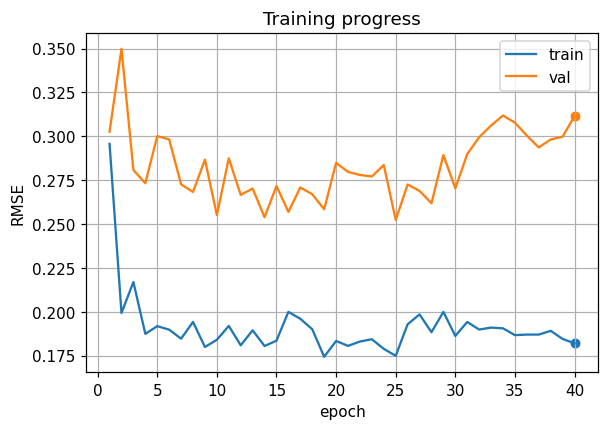

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.2957 • val=0.3026 • lr=9.27e-03


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.1993 • val=0.3499 • lr=9.25e-03


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2169 • val=0.2808 • lr=9.22e-03


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.1874 • val=0.2732 • lr=9.18e-03


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.1918 • val=0.3001 • lr=9.12e-03


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.1898 • val=0.2982 • lr=9.05e-03


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.1847 • val=0.2726 • lr=8.97e-03


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.1942 • val=0.2683 • lr=8.88e-03


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.1799 • val=0.2867 • lr=8.77e-03


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.1840 • val=0.2551 • lr=8.66e-03


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.1919 • val=0.2875 • lr=8.53e-03


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.1809 • val=0.2666 • lr=8.40e-03


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.1894 • val=0.2702 • lr=8.25e-03


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.1805 • val=0.2539 • lr=8.09e-03


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.1835 • val=0.2717 • lr=7.93e-03


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.1999 • val=0.2569 • lr=7.75e-03


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.1960 • val=0.2708 • lr=7.57e-03


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.1900 • val=0.2670 • lr=7.37e-03


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.1743 • val=0.2584 • lr=7.18e-03


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.1833 • val=0.2848 • lr=6.97e-03


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.1806 • val=0.2797 • lr=6.76e-03


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.1830 • val=0.2780 • lr=6.54e-03


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.1844 • val=0.2771 • lr=6.31e-03


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.1789 • val=0.2836 • lr=6.09e-03


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.1749 • val=0.2524 • lr=5.85e-03


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.1929 • val=0.2725 • lr=5.62e-03


Epoch 27:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 027 • train=0.1985 • val=0.2688 • lr=5.38e-03


Epoch 28:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 028 • train=0.1884 • val=0.2618 • lr=5.14e-03


Epoch 29:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 029 • train=0.1999 • val=0.2893 • lr=4.90e-03


Epoch 30:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 030 • train=0.1862 • val=0.2704 • lr=4.66e-03


Epoch 31:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 031 • train=0.1942 • val=0.2899 • lr=4.42e-03


Epoch 32:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 032 • train=0.1899 • val=0.2995 • lr=4.18e-03


Epoch 33:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 033 • train=0.1910 • val=0.3062 • lr=3.94e-03


Epoch 34:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 034 • train=0.1906 • val=0.3118 • lr=3.70e-03


Epoch 35:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 035 • train=0.1867 • val=0.3078 • lr=3.46e-03


Epoch 36:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 036 • train=0.1870 • val=0.3004 • lr=3.23e-03


Epoch 37:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 037 • train=0.1870 • val=0.2936 • lr=3.00e-03


Epoch 38:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 038 • train=0.1892 • val=0.2982 • lr=2.78e-03


Epoch 39:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 039 • train=0.1845 • val=0.2998 • lr=2.56e-03


Epoch 40:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 040 • train=0.1820 • val=0.3115 • lr=2.35e-03
Early stopping at epoch 40


[I 2025-07-27 05:53:49,942] Trial 16 finished with value: 0.2523554626049102 and parameters: {'DROPOUT_SHORT': 0.2, 'DROPOUT_LONG': 0.35, 'ATT_HEADS': 4, 'ATT_DROPOUT': 0.15, 'INITIAL_LR': 0.009276829901727126, 'ETA_MIN': 3.3114157297327326e-05, 'WEIGHT_DECAY': 0.003, 'CLIPNORM': 0.5, 'LR_EPOCHS_WARMUP': 3}. Best is trial 14 with value: 0.25080742856736177.



▶ Trial 17 starting with:
{'DROPOUT_SHORT': 0.2, 'DROPOUT_LONG': 0.35, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.15, 'INITIAL_LR': 0.009301932424045381, 'ETA_MIN': 3.160338160076634e-05, 'WEIGHT_DECAY': 0.003, 'CLIPNORM': 0.5, 'LR_EPOCHS_WARMUP': 3}



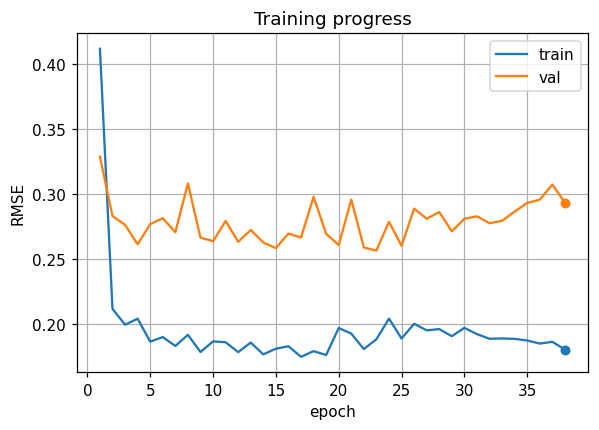

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.4117 • val=0.3287 • lr=9.30e-03


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2117 • val=0.2830 • lr=9.28e-03


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.1995 • val=0.2763 • lr=9.25e-03


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2042 • val=0.2613 • lr=9.20e-03


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.1865 • val=0.2769 • lr=9.15e-03


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.1900 • val=0.2814 • lr=9.08e-03


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.1832 • val=0.2706 • lr=9.00e-03


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.1918 • val=0.3082 • lr=8.90e-03


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.1785 • val=0.2665 • lr=8.80e-03


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.1867 • val=0.2638 • lr=8.68e-03


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.1861 • val=0.2792 • lr=8.56e-03


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.1785 • val=0.2632 • lr=8.42e-03


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.1858 • val=0.2724 • lr=8.27e-03


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.1767 • val=0.2628 • lr=8.11e-03


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.1811 • val=0.2584 • lr=7.95e-03


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.1829 • val=0.2696 • lr=7.77e-03


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.1749 • val=0.2665 • lr=7.59e-03


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.1792 • val=0.2978 • lr=7.39e-03


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.1762 • val=0.2694 • lr=7.19e-03


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.1970 • val=0.2608 • lr=6.99e-03


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.1927 • val=0.2957 • lr=6.77e-03


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.1808 • val=0.2589 • lr=6.56e-03


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.1884 • val=0.2566 • lr=6.33e-03


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.2042 • val=0.2787 • lr=6.10e-03


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.1889 • val=0.2602 • lr=5.87e-03


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.2002 • val=0.2888 • lr=5.63e-03


Epoch 27:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 027 • train=0.1952 • val=0.2810 • lr=5.40e-03


Epoch 28:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 028 • train=0.1962 • val=0.2861 • lr=5.16e-03


Epoch 29:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 029 • train=0.1907 • val=0.2714 • lr=4.91e-03


Epoch 30:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 030 • train=0.1971 • val=0.2810 • lr=4.67e-03


Epoch 31:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 031 • train=0.1923 • val=0.2829 • lr=4.43e-03


Epoch 32:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 032 • train=0.1887 • val=0.2776 • lr=4.19e-03


Epoch 33:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 033 • train=0.1890 • val=0.2794 • lr=3.95e-03


Epoch 34:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 034 • train=0.1886 • val=0.2865 • lr=3.71e-03


Epoch 35:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 035 • train=0.1874 • val=0.2932 • lr=3.47e-03


Epoch 36:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 036 • train=0.1850 • val=0.2957 • lr=3.24e-03


Epoch 37:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 037 • train=0.1863 • val=0.3073 • lr=3.01e-03


Epoch 38:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 038 • train=0.1805 • val=0.2934 • lr=2.79e-03
Early stopping at epoch 38


[I 2025-07-27 06:32:23,675] Trial 17 finished with value: 0.25656405449353126 and parameters: {'DROPOUT_SHORT': 0.2, 'DROPOUT_LONG': 0.35, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.15, 'INITIAL_LR': 0.009301932424045381, 'ETA_MIN': 3.160338160076634e-05, 'WEIGHT_DECAY': 0.003, 'CLIPNORM': 0.5, 'LR_EPOCHS_WARMUP': 3}. Best is trial 14 with value: 0.25080742856736177.



▶ Trial 18 starting with:
{'DROPOUT_SHORT': 0.2, 'DROPOUT_LONG': 0.35, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.15, 'INITIAL_LR': 0.008760890766819416, 'ETA_MIN': 1.148658515497109e-05, 'WEIGHT_DECAY': 0.003, 'CLIPNORM': 0.5, 'LR_EPOCHS_WARMUP': 1}



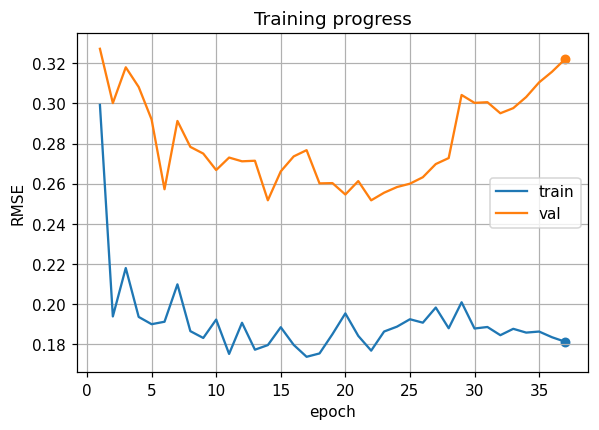

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.2992 • val=0.3272 • lr=8.76e-03


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.1939 • val=0.3001 • lr=8.74e-03


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2180 • val=0.3179 • lr=8.71e-03


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.1937 • val=0.3081 • lr=8.67e-03


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.1901 • val=0.2919 • lr=8.61e-03


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.1913 • val=0.2572 • lr=8.55e-03


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2099 • val=0.2912 • lr=8.47e-03


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.1866 • val=0.2783 • lr=8.38e-03


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.1832 • val=0.2750 • lr=8.29e-03


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.1924 • val=0.2668 • lr=8.18e-03


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.1753 • val=0.2730 • lr=8.06e-03


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.1908 • val=0.2712 • lr=7.93e-03


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.1774 • val=0.2714 • lr=7.79e-03


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.1797 • val=0.2517 • lr=7.64e-03


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.1886 • val=0.2661 • lr=7.48e-03


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.1798 • val=0.2736 • lr=7.32e-03


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.1738 • val=0.2767 • lr=7.14e-03


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.1755 • val=0.2602 • lr=6.96e-03


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.1851 • val=0.2603 • lr=6.77e-03


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.1954 • val=0.2546 • lr=6.58e-03


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.1843 • val=0.2613 • lr=6.38e-03


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.1769 • val=0.2517 • lr=6.17e-03


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.1864 • val=0.2555 • lr=5.96e-03


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.1889 • val=0.2583 • lr=5.74e-03


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.1925 • val=0.2600 • lr=5.52e-03


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.1908 • val=0.2632 • lr=5.30e-03


Epoch 27:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 027 • train=0.1984 • val=0.2698 • lr=5.07e-03


Epoch 28:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 028 • train=0.1881 • val=0.2728 • lr=4.85e-03


Epoch 29:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 029 • train=0.2010 • val=0.3042 • lr=4.62e-03


Epoch 30:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 030 • train=0.1879 • val=0.3002 • lr=4.39e-03


Epoch 31:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 031 • train=0.1887 • val=0.3006 • lr=4.16e-03


Epoch 32:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 032 • train=0.1846 • val=0.2951 • lr=3.93e-03


Epoch 33:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 033 • train=0.1878 • val=0.2976 • lr=3.71e-03


Epoch 34:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 034 • train=0.1859 • val=0.3032 • lr=3.48e-03


Epoch 35:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 035 • train=0.1864 • val=0.3104 • lr=3.26e-03


Epoch 36:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 036 • train=0.1836 • val=0.3157 • lr=3.04e-03


Epoch 37:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 037 • train=0.1814 • val=0.3220 • lr=2.82e-03
Early stopping at epoch 37


[I 2025-07-27 07:10:06,471] Trial 18 finished with value: 0.25172747567927045 and parameters: {'DROPOUT_SHORT': 0.2, 'DROPOUT_LONG': 0.35, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.15, 'INITIAL_LR': 0.008760890766819416, 'ETA_MIN': 1.148658515497109e-05, 'WEIGHT_DECAY': 0.003, 'CLIPNORM': 0.5, 'LR_EPOCHS_WARMUP': 1}. Best is trial 14 with value: 0.25080742856736177.



▶ Trial 19 starting with:
{'DROPOUT_SHORT': 0.2, 'DROPOUT_LONG': 0.35, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.15, 'INITIAL_LR': 0.008480480497080453, 'ETA_MIN': 1.4513774142310689e-05, 'WEIGHT_DECAY': 0.003, 'CLIPNORM': 0.7, 'LR_EPOCHS_WARMUP': 1}



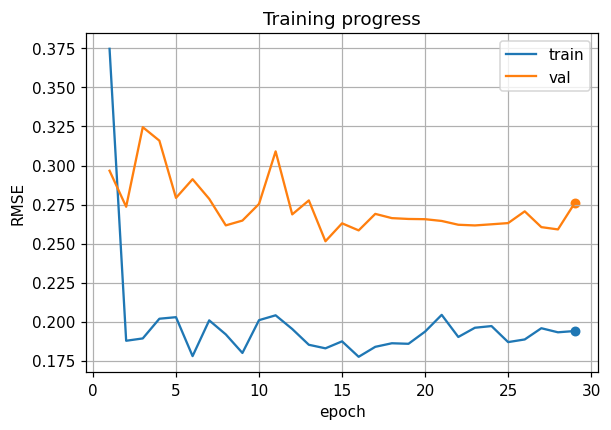

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.3748 • val=0.2967 • lr=8.47e-03


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.1878 • val=0.2736 • lr=8.46e-03


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.1893 • val=0.3246 • lr=8.43e-03


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2019 • val=0.3159 • lr=8.39e-03


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2029 • val=0.2793 • lr=8.34e-03


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.1779 • val=0.2912 • lr=8.27e-03


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2008 • val=0.2787 • lr=8.20e-03


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.1918 • val=0.2617 • lr=8.12e-03


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.1800 • val=0.2647 • lr=8.02e-03


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2010 • val=0.2754 • lr=7.92e-03


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2041 • val=0.3091 • lr=7.80e-03


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.1953 • val=0.2687 • lr=7.67e-03


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.1852 • val=0.2777 • lr=7.54e-03


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.1829 • val=0.2515 • lr=7.40e-03


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.1874 • val=0.2630 • lr=7.24e-03


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.1775 • val=0.2585 • lr=7.08e-03


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.1839 • val=0.2690 • lr=6.91e-03


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.1862 • val=0.2663 • lr=6.74e-03


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.1858 • val=0.2658 • lr=6.56e-03


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.1936 • val=0.2656 • lr=6.37e-03


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.2044 • val=0.2645 • lr=6.17e-03


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.1902 • val=0.2621 • lr=5.97e-03


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.1961 • val=0.2616 • lr=5.77e-03


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.1972 • val=0.2624 • lr=5.56e-03


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.1869 • val=0.2631 • lr=5.35e-03


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.1886 • val=0.2706 • lr=5.13e-03


Epoch 27:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 027 • train=0.1958 • val=0.2605 • lr=4.91e-03


Epoch 28:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 028 • train=0.1932 • val=0.2591 • lr=4.69e-03


Epoch 29:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 029 • train=0.1940 • val=0.2758 • lr=4.47e-03
Early stopping at epoch 29


[I 2025-07-27 07:39:44,563] Trial 19 finished with value: 0.2514879914837166 and parameters: {'DROPOUT_SHORT': 0.2, 'DROPOUT_LONG': 0.35, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.15, 'INITIAL_LR': 0.008480480497080453, 'ETA_MIN': 1.4513774142310689e-05, 'WEIGHT_DECAY': 0.003, 'CLIPNORM': 0.7, 'LR_EPOCHS_WARMUP': 1}. Best is trial 14 with value: 0.25080742856736177.



▶ Trial 20 starting with:
{'DROPOUT_SHORT': 0.2, 'DROPOUT_LONG': 0.35, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.15, 'INITIAL_LR': 0.007335380620974314, 'ETA_MIN': 1.2151057534098555e-05, 'WEIGHT_DECAY': 0.003, 'CLIPNORM': 0.7, 'LR_EPOCHS_WARMUP': 1}



/workspace/my_models/Trading/_Stock_Analysis_/libs/plots.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self.fig, self.ax = plt.subplots(figsize=(6, 4), dpi=110)


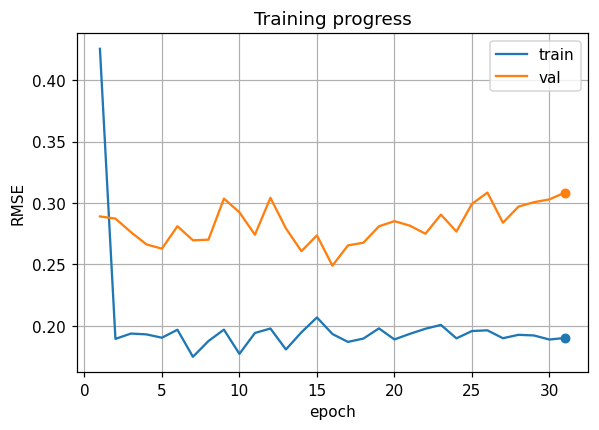

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.4257 • val=0.2891 • lr=7.33e-03


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.1893 • val=0.2873 • lr=7.32e-03


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.1937 • val=0.2763 • lr=7.29e-03


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.1930 • val=0.2663 • lr=7.26e-03


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.1903 • val=0.2628 • lr=7.21e-03


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.1968 • val=0.2811 • lr=7.16e-03


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.1747 • val=0.2696 • lr=7.09e-03


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.1875 • val=0.2701 • lr=7.02e-03


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.1969 • val=0.3036 • lr=6.94e-03


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.1771 • val=0.2924 • lr=6.85e-03


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.1941 • val=0.2742 • lr=6.75e-03


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.1978 • val=0.3042 • lr=6.64e-03


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.1807 • val=0.2793 • lr=6.52e-03


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.1947 • val=0.2608 • lr=6.40e-03


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.2068 • val=0.2736 • lr=6.27e-03


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.1933 • val=0.2490 • lr=6.13e-03
Saved new best model: GOOGL_0.2490.pth


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.1869 • val=0.2655 • lr=5.98e-03


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.1896 • val=0.2677 • lr=5.83e-03


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.1979 • val=0.2810 • lr=5.67e-03


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.1889 • val=0.2852 • lr=5.51e-03


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.1934 • val=0.2815 • lr=5.34e-03


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.1976 • val=0.2750 • lr=5.17e-03


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.2007 • val=0.2906 • lr=4.99e-03


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.1897 • val=0.2768 • lr=4.81e-03


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.1957 • val=0.2993 • lr=4.62e-03


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.1963 • val=0.3085 • lr=4.44e-03


Epoch 27:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 027 • train=0.1898 • val=0.2840 • lr=4.25e-03


Epoch 28:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 028 • train=0.1926 • val=0.2971 • lr=4.06e-03


Epoch 29:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 029 • train=0.1921 • val=0.3007 • lr=3.87e-03


Epoch 30:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 030 • train=0.1888 • val=0.3030 • lr=3.68e-03


Epoch 31:   0%|          | 0/62 [00:00<?, ?bundle/s]

[I 2025-07-27 08:11:29,355] Trial 20 finished with value: 0.24897546799402104 and parameters: {'DROPOUT_SHORT': 0.2, 'DROPOUT_LONG': 0.35, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.15, 'INITIAL_LR': 0.007335380620974314, 'ETA_MIN': 1.2151057534098555e-05, 'WEIGHT_DECAY': 0.003, 'CLIPNORM': 0.7, 'LR_EPOCHS_WARMUP': 1}. Best is trial 20 with value: 0.24897546799402104.


Epoch 031 • train=0.1901 • val=0.3085 • lr=3.49e-03
Early stopping at epoch 31

▶ Trial 21 starting with:
{'DROPOUT_SHORT': 0.2, 'DROPOUT_LONG': 0.35, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.15, 'INITIAL_LR': 0.007393306981168604, 'ETA_MIN': 1.1975378940099365e-05, 'WEIGHT_DECAY': 0.003, 'CLIPNORM': 0.7, 'LR_EPOCHS_WARMUP': 1}



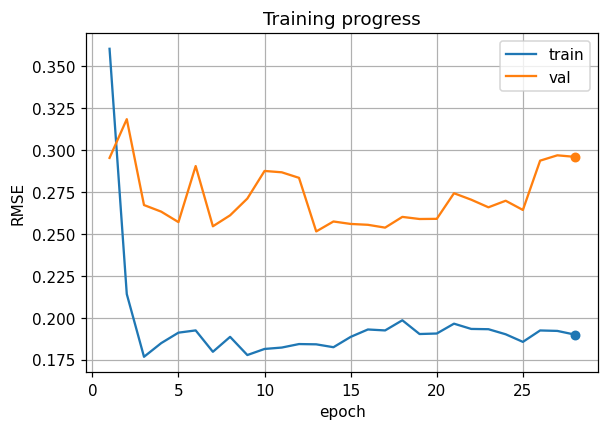

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.3604 • val=0.2953 • lr=7.39e-03


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2141 • val=0.3185 • lr=7.37e-03


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.1767 • val=0.2672 • lr=7.35e-03


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.1849 • val=0.2633 • lr=7.31e-03


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.1911 • val=0.2570 • lr=7.27e-03


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.1924 • val=0.2905 • lr=7.21e-03


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.1797 • val=0.2546 • lr=7.15e-03


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.1886 • val=0.2611 • lr=7.08e-03


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.1777 • val=0.2711 • lr=6.99e-03


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.1814 • val=0.2876 • lr=6.90e-03


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.1822 • val=0.2868 • lr=6.80e-03


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.1843 • val=0.2834 • lr=6.69e-03


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.1841 • val=0.2515 • lr=6.57e-03


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.1824 • val=0.2574 • lr=6.45e-03


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.1886 • val=0.2559 • lr=6.31e-03


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.1930 • val=0.2554 • lr=6.17e-03


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.1924 • val=0.2537 • lr=6.03e-03


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.1985 • val=0.2602 • lr=5.87e-03


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.1903 • val=0.2589 • lr=5.72e-03


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.1906 • val=0.2590 • lr=5.55e-03


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.1965 • val=0.2743 • lr=5.38e-03


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.1933 • val=0.2704 • lr=5.21e-03


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.1932 • val=0.2659 • lr=5.03e-03


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.1901 • val=0.2698 • lr=4.85e-03


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.1856 • val=0.2643 • lr=4.66e-03


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.1924 • val=0.2937 • lr=4.47e-03


Epoch 27:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 027 • train=0.1921 • val=0.2969 • lr=4.28e-03


Epoch 28:   0%|          | 0/62 [00:00<?, ?bundle/s]

[I 2025-07-27 08:40:46,130] Trial 21 finished with value: 0.25147858171056126 and parameters: {'DROPOUT_SHORT': 0.2, 'DROPOUT_LONG': 0.35, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.15, 'INITIAL_LR': 0.007393306981168604, 'ETA_MIN': 1.1975378940099365e-05, 'WEIGHT_DECAY': 0.003, 'CLIPNORM': 0.7, 'LR_EPOCHS_WARMUP': 1}. Best is trial 20 with value: 0.24897546799402104.


Epoch 028 • train=0.1900 • val=0.2960 • lr=4.09e-03
Early stopping at epoch 28

▶ Trial 22 starting with:
{'DROPOUT_SHORT': 0.2, 'DROPOUT_LONG': 0.35, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.15, 'INITIAL_LR': 0.007323599405917095, 'ETA_MIN': 3.607675700538177e-05, 'WEIGHT_DECAY': 0.003, 'CLIPNORM': 0.7, 'LR_EPOCHS_WARMUP': 1}



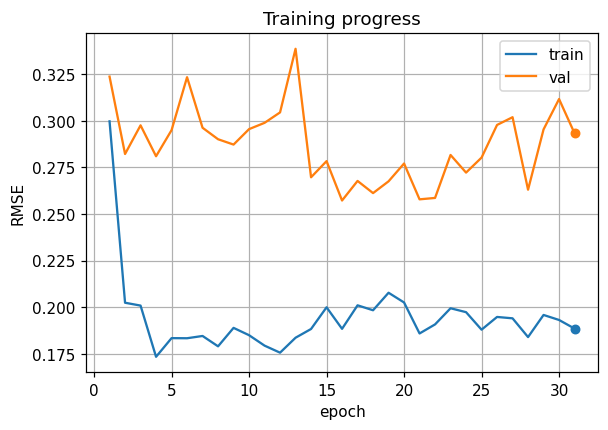

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.2997 • val=0.3237 • lr=7.32e-03


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2024 • val=0.2822 • lr=7.30e-03


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2008 • val=0.2976 • lr=7.28e-03


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.1734 • val=0.2810 • lr=7.24e-03


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.1834 • val=0.2950 • lr=7.20e-03


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.1833 • val=0.3234 • lr=7.15e-03


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.1845 • val=0.2963 • lr=7.08e-03


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.1790 • val=0.2901 • lr=7.01e-03


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.1889 • val=0.2873 • lr=6.93e-03


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.1849 • val=0.2955 • lr=6.84e-03


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.1794 • val=0.2989 • lr=6.74e-03


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.1756 • val=0.3045 • lr=6.63e-03


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.1836 • val=0.3387 • lr=6.51e-03


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.1883 • val=0.2697 • lr=6.39e-03


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.1999 • val=0.2784 • lr=6.26e-03


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.1884 • val=0.2572 • lr=6.12e-03


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.2010 • val=0.2677 • lr=5.98e-03


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.1983 • val=0.2612 • lr=5.82e-03


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.2077 • val=0.2675 • lr=5.67e-03


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.2025 • val=0.2771 • lr=5.50e-03


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.1859 • val=0.2579 • lr=5.34e-03


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.1907 • val=0.2586 • lr=5.16e-03


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.1994 • val=0.2817 • lr=4.99e-03


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.1973 • val=0.2722 • lr=4.81e-03


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.1879 • val=0.2803 • lr=4.63e-03


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.1947 • val=0.2978 • lr=4.44e-03


Epoch 27:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 027 • train=0.1940 • val=0.3019 • lr=4.25e-03


Epoch 28:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 028 • train=0.1839 • val=0.2630 • lr=4.06e-03


Epoch 29:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 029 • train=0.1958 • val=0.2954 • lr=3.87e-03


Epoch 30:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 030 • train=0.1931 • val=0.3117 • lr=3.68e-03


Epoch 31:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 031 • train=0.1885 • val=0.2933 • lr=3.49e-03
Early stopping at epoch 31


[I 2025-07-27 09:12:42,136] Trial 22 finished with value: 0.2572382598156815 and parameters: {'DROPOUT_SHORT': 0.2, 'DROPOUT_LONG': 0.35, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.15, 'INITIAL_LR': 0.007323599405917095, 'ETA_MIN': 3.607675700538177e-05, 'WEIGHT_DECAY': 0.003, 'CLIPNORM': 0.7, 'LR_EPOCHS_WARMUP': 1}. Best is trial 20 with value: 0.24897546799402104.



▶ Trial 23 starting with:
{'DROPOUT_SHORT': 0.2, 'DROPOUT_LONG': 0.35, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.15, 'INITIAL_LR': 0.0011938920223383501, 'ETA_MIN': 2.598520106775369e-05, 'WEIGHT_DECAY': 0.003, 'CLIPNORM': 0.7, 'LR_EPOCHS_WARMUP': 1}



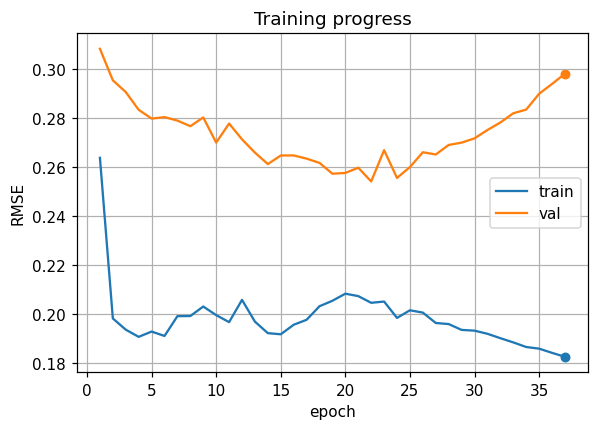

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.2638 • val=0.3084 • lr=1.19e-03


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.1982 • val=0.2955 • lr=1.19e-03


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.1936 • val=0.2907 • lr=1.19e-03


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.1907 • val=0.2834 • lr=1.18e-03


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.1928 • val=0.2798 • lr=1.17e-03


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.1910 • val=0.2804 • lr=1.17e-03


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.1991 • val=0.2790 • lr=1.16e-03


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.1992 • val=0.2767 • lr=1.14e-03


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2030 • val=0.2803 • lr=1.13e-03


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.1995 • val=0.2700 • lr=1.12e-03


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.1967 • val=0.2778 • lr=1.10e-03


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2058 • val=0.2714 • lr=1.08e-03


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.1969 • val=0.2659 • lr=1.06e-03


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.1922 • val=0.2612 • lr=1.04e-03


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.1917 • val=0.2648 • lr=1.02e-03


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.1956 • val=0.2648 • lr=1.00e-03


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.1976 • val=0.2635 • lr=9.78e-04


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.2032 • val=0.2617 • lr=9.54e-04


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.2054 • val=0.2573 • lr=9.28e-04


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.2083 • val=0.2576 • lr=9.02e-04


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.2073 • val=0.2598 • lr=8.75e-04


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.2046 • val=0.2542 • lr=8.48e-04


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.2051 • val=0.2669 • lr=8.20e-04


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.1984 • val=0.2556 • lr=7.91e-04


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.2015 • val=0.2600 • lr=7.62e-04


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.2006 • val=0.2661 • lr=7.32e-04


Epoch 27:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 027 • train=0.1963 • val=0.2652 • lr=7.02e-04


Epoch 28:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 028 • train=0.1959 • val=0.2691 • lr=6.71e-04


Epoch 29:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 029 • train=0.1935 • val=0.2700 • lr=6.41e-04


Epoch 30:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 030 • train=0.1932 • val=0.2718 • lr=6.10e-04


Epoch 31:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 031 • train=0.1919 • val=0.2752 • lr=5.80e-04


Epoch 32:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 032 • train=0.1901 • val=0.2782 • lr=5.49e-04


Epoch 33:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 033 • train=0.1884 • val=0.2820 • lr=5.19e-04


Epoch 34:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 034 • train=0.1865 • val=0.2835 • lr=4.89e-04


Epoch 35:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 035 • train=0.1858 • val=0.2900 • lr=4.59e-04


Epoch 36:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 036 • train=0.1841 • val=0.2940 • lr=4.30e-04


Epoch 37:   0%|          | 0/62 [00:00<?, ?bundle/s]

[I 2025-07-27 09:51:28,603] Trial 23 finished with value: 0.2541552642498158 and parameters: {'DROPOUT_SHORT': 0.2, 'DROPOUT_LONG': 0.35, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.15, 'INITIAL_LR': 0.0011938920223383501, 'ETA_MIN': 2.598520106775369e-05, 'WEIGHT_DECAY': 0.003, 'CLIPNORM': 0.7, 'LR_EPOCHS_WARMUP': 1}. Best is trial 20 with value: 0.24897546799402104.


Epoch 037 • train=0.1825 • val=0.2982 • lr=4.01e-04
Early stopping at epoch 37

▶ Trial 24 starting with:
{'DROPOUT_SHORT': 0.2, 'DROPOUT_LONG': 0.35, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.15, 'INITIAL_LR': 0.005303011090704005, 'ETA_MIN': 1.1143684657705308e-05, 'WEIGHT_DECAY': 0.003, 'CLIPNORM': 0.7, 'LR_EPOCHS_WARMUP': 1}



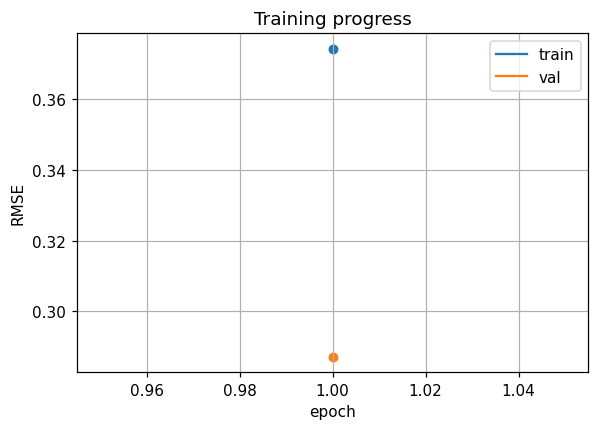

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.3743 • val=0.2872 • lr=5.30e-03


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
#  Create Optuna study and run optimization
# ──────────────────────────────────────────────────────────────────────────────

study = optuna.create_study(
    storage="sqlite:///optuna_study.db",    # Point it at an SQLite file so it writes out each result immediately instead of buffering in RAM
    load_if_exists=True,
    direction="minimize",
    pruner=MedianPruner(n_startup_trials=6, n_warmup_steps=12),
)

def cleanup_cb(study, trial):
    # Python‐side
    gc.collect()
    # CUDA‐side (no‐op on CPU only)
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        
study.optimize(
    objective_train,
    n_trials = 120,
    n_jobs   = 1,
    callbacks=[live_cb, cleanup_cb],
)

# ──────────────────────────────────────────────────────────────────────────────
#  Print out the best hyperparameters & result
# ──────────────────────────────────────────────────────────────────────────────
print("Best hyperparameters:", study.best_params)
print("Best validation RMSE:", study.best_value)

# ──────────────────────────────────────────────────────────────────────────────
#  Compute and print parameter importances
# ──────────────────────────────────────────────────────────────────────────────
imps = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact on RMSE):")
for name, score in sorted(imps.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s} : {score:.3f}")

# ──────────────────────────────────────────────────────────────────────────────
#  Dump study results to JSON
# ──────────────────────────────────────────────────────────────────────────────
# 1) Build your session‐only DataFrame once
session_df = df.between_time(params.regular_start,
                             params.regular_end)

# 2) Derive the trading‐day boundaries
first_day = session_df.index.normalize().min()
last_day  = session_df.index.normalize().max()

# 3) Format your file name
start_date = first_day.strftime("%Y%m%d")
end_date   = last_day.strftime("%Y%m%d")
file_name  = f"{ticker}_{start_date}-{end_date}_optuna_model_hpars.json"
file_path  = os.path.join(results_folder, file_name)


# ------------------------------------------------------------------
# Dump study results (including importances)
# ------------------------------------------------------------------

with open(file_path, "w") as f:
    json.dump(
        {
            "best_params": study.best_params,
            "best_value" : study.best_value,
            "importances": imps,
            "trials": [
                {"number": t.number, "value": t.value, "params": t.params, 
                 "state": t.state.name}
                for t in study.trials
            ],
        },
        f,
        indent=4,
    )

print(f"\nOptuna results (and importances) saved to: {file_path}")
